# NAC coloring search

In this notebook we provide utilities to run benchmarks, analyze results and experiment with our code.
As the package is still in development, not all parts must be user-friendly, still we try to provide good enough description and usable abstraction.

First we provide class for loading graph classes,
then a simple function for measuring performance of listing all NAC-colorings on a graph class.
Then we define how strategies are passed to our algorithm,
and after a framework for defining and running benchmarks.
Lastly, we provide tools for quick results analysis.

Many utility functions were moved from the notebook
into a separate file to improve clarity, see `benchmarks/notebook_utils.py`.

Make sure the `nac` directory is in your working directory, and that you installed `requierements.txt` into your virtual environment.
Also, make sure to uncompressed files in `benchmarks/precomputed` if you want to analyze our result yourself.

In [1]:
from typing import *
import importlib
from collections import deque

import numpy as np
import pandas as pd
import networkx as nx
import os
import time
import datetime
import signal
import itertools
import base64

from tqdm import tqdm

import nac as nac
import nac.util
from nac import MonochromaticClassType
importlib.reload(nac)
importlib.reload(nac.util)

import benchmarks
from benchmarks import dataset
import benchmarks.notebook_utils
from benchmarks.notebook_utils import *
importlib.reload(benchmarks)
importlib.reload(dataset)
importlib.reload(benchmarks.notebook_utils)

seed=42

### Benchmarks directory

You can either choose to use our precomputed results or run the benchmarks yourself.
The algorithms take usually tens or hunderes of miliseconds to run,
but there is plenty of graphs and strategies combinations, so times add up.

In [2]:
OUTPUT_DIR_PRECOMPUTED = os.path.join("benchmarks", "precomputed")
OUTPUT_DIR_LOCAL = os.path.join("benchmarks", "local")

benchmarks.notebook_utils.OUTPUT_DIR = OUTPUT_DIR_PRECOMPUTED
os.makedirs(benchmarks.notebook_utils.OUTPUT_DIR, exist_ok=True)

# Loading graph classes

In this section we load graphs that can be later used for running benchmarks.
The graphs are not in any specified order and they differ in size ranges.
Graphs are stored in the `graph6` format in the `graphs_store` directory.

In [3]:
class Graphs:
    """
    Randomly generated minimally rigid (Laman) graphs of various sizes
    """
    minimally_rigid_random = LazyList(lambda: dataset.load_laman_random_graphs())
    """
    Graphs with no 3 nor 4 cycles up to 42 vertices
    """
    no_3_nor_4_cycles = LazyList(lambda: dataset.load_no_3_nor_4_cycle_graphs())
    """
    Randomly generated globally rigid graphs
    """
    globally_rigid = LazyList(lambda: dataset.load_globally_rigid_graphs())
    """
    Random (globally rigid) graphs that have no NAC-coloring and more than 2*sqrt(n) triangle-connected components
    """
    no_NAC_coloring_generated_40 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(40))
    no_NAC_coloring_generated_50 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(50))
    no_NAC_coloring_generated_60 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(60))
    no_NAC_coloring_generated_70 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(70))
    no_NAC_coloring_generated_80 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(80))
    no_NAC_coloring_generated_90 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(90))
    no_NAC_coloring_generated_100 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(100))
    no_NAC_coloring_generated_110 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(110))
    no_NAC_coloring_generated_120 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(120))
    no_NAC_coloring_generated_130 = LazyList(lambda: dataset.load_no_NAC_coloring_graphs_generated(130))

    """
    Loads all the minimally rigid (Laman) graphs of the given size, pregenerated files allow the range of [5, 11]
    """
    def load_all_minimally_rigid(vertex_no: int) -> List[nx.Graph]:
        return list(dataset.load_laman_all(vertices_no=vertex_no))

# Running on all minimally rigid graphs

This is a function that can be used for benchmarking of finding all the NAC-colorings of some graph class.
This function can provide only total times, not runtime per graph. That is the job of the following benchmarks.

In [4]:
def benchmarks_all_NAC_coloring_on_class(
    graphs: List[nx.Graph],
    rounds: int,
    strategy: str,
    use_monochromatic_classes: bool,
    use_has_coloring_check: bool = False,
) -> float:
    start = time.time()
    monochromatic_class_type=nac.MonochromaticClassType.MONOCHROMATIC if use_monochromatic_classes else nac.MonochromaticClassType.TRIANGLES

    for _ in range(rounds):
        for graph in graphs:
            # the fastest way to collect an iterable in Python
            deque(nac.NAC_colorings(
                graph,
                relabel_strategy="none",
                algorithm=strategy,
                monochromatic_class_type=monochromatic_class_type,
                use_has_coloring_check=use_has_coloring_check,
            ), 0)

    return (time.time() - start) / rounds

def benchmarks_all_NAC_coloring_minimally_rigid(
    vertex_no: int,
    rounds: int,
):
    graphs = list(Graphs.load_all_minimally_rigid(vertex_no))
    for strategy, use_monochromatic_classes in [
        ('naive', False),
        ('naive', True),
        ('cycles', True),
        ('subgraphs-linear-neighbors_degree-4', True),
    ]:
        print(f"[{vertex_no:2}]: # {strategy} (monochrom: {use_monochromatic_classes})")
        runtime = benchmarks_all_NAC_coloring_on_class(
            graphs=graphs,
            rounds=rounds,
            strategy=strategy,
            use_monochromatic_classes=use_monochromatic_classes,
        )
        print(f"[{vertex_no:2}]: > {runtime:.3f} s")

if False: # Change to enable
    for n in range(5, 11+1):
        benchmarks_all_NAC_coloring_minimally_rigid(
            vertex_no=n,
            rounds=3 if n <= 10 else 1,
        )

# Storing and loading benchmark results

Each row represents performance of a graph with a given strategy.
The difference between the first and all variant is that
in the all variants we search for all NAC-colorings,
but in the first variant we search only.

The export CSV columns are:
- `timestamp` - date time of the test in UTC
- `graph` - base64 encoded bytes of graph6 encoded graph
- `dataset` - class of the graph, `minimally_ridig_random`, `no_3_nor_4_cycles`, `globally_rigid`, ...
- `vertex_no` - the number of vertices of the graph
- `edge_no` - the number of edges of the graph
- `triangle_components_no` - the number of triangle components of the graph
- `monochromatic_classes_no` - the number of monochromatic classes of the graph
- `relabel` - relabel strategy (relabels vertices before the main algorithm is run, here we have only `none` or `random`)
- `split` - splitting strategy
- `merge` - merging strategy
- `subgraph_size` - the target initial size of subgraphs in monochromatic components
- `used_monochromatic_classes` - if monochromatic classes were used to run the test, `False` means triangle components were used
- `nac_any_finished` - if any of the tests finished in time
- `nac_{first|all}_coloring_no` - the number of NAC-colorings of the graph, for the first variant limited to 1
- `nac_{first|all}_mean_time` - the time required to find first/all NAC-colorings in milliseconds
- `nac_{first|all}_rounds` - the number of rounds used to run the benchmarks
- `nac_{first|all}_check_cycle_mask` - the number of cycle mask checks performed
- `nac_{first|all}_check_is_NAC` - the number of `IsNACColorng` checks performed
- `nac_{first|all}_merge` - the number of merges performed
- `nac_{first|all}_merge_no_common_vertex` - the number of merges with no common vertex (these are simple to compute, but produce large no of colorings slowing down the algorithm)

In [5]:
display(COLUMNS)

['timestamp',
 'graph',
 'dataset',
 'vertex_no',
 'edge_no',
 'triangle_components_no',
 'monochromatic_classes_no',
 'relabel',
 'split',
 'merging',
 'subgraph_size',
 'use_smart_split',
 'used_monochromatic_classes',
 'nac_any_finished',
 'nac_first_coloring_no',
 'nac_first_mean_time',
 'nac_first_rounds',
 'nac_first_check_is_NAC',
 'nac_first_check_cycle_mask',
 'nac_first_merge',
 'nac_first_merge_no_common_vertex',
 'nac_all_coloring_no',
 'nac_all_mean_time',
 'nac_all_rounds',
 'nac_all_check_is_NAC',
 'nac_all_check_cycle_mask',
 'nac_all_merge',
 'nac_all_merge_no_common_vertex']

# Strategies

The interface of the NAC-coloring search function looks like this:
```python
def NAC_colorings(
    graph: nx.Graph,
    algorithm: str = "subgraphs",
    relabel_strategy: str = "none",
    monochromatic_class_type: MonochromaticClassType = MonochromaticClassType.MONOCHROMATIC,
    use_decompositions: bool = True,
    use_has_coloring_check: bool = True,
    seed: int | None = None,
) -> Iterable[NACColoring]:
```

The relabel strategy is either `"none"` or `"random"`.
`MonochromaticClassType` types are `MONOCHROMATIC` that creates monochromatic classes as described in the paper,
`TRIANGLES` that finds only triangle connected components and
`EDGES` that uses no monochromatic classes optimization.
The `use_decompositions` switch is responsible for enabling checks for articulation points and related decomposition into blocks.
The `use_has_coloring_check` runs some polynomial checks if a NAC-coloring can exist. If not, the whole search is skipped.
`seed` is used by strategies internally as only pseudo random number generators are used.

The most important field is the `algorithm` field.
Possible values are:
- `"naive"` - runs naive algorithm
- `"cycles"` - runs naive algorithm improved by cycles detection
- `"subgraphs"` - runs so far optimal algorithm for larger graphs based on subgraph decomposition
- `"subgraphs-{merge_strategy}-{split_strategy}-{size_of_subgraphs}"` - runs the specified strategy combination with subgraph decomposition

In our code strategies are represented as four-tupples.

In [6]:
class Promising:
    RELABELING = [
        "none",
        # random strategy is disabled as we use randomly generated graphs
        # "random",
    ]
    SPLITTING = [
        "none",
        "cycles_match_chunks",
        "neighbors",
        "neighbors_degree",
    ]
    MERGE = [
        "linear",
        "shared_vertices",
    ]
    # This is not optimal for every graph, but does not hurt performance significantly
    SIZES = [6]

    strategies = list(itertools.product(
        RELABELING, SPLITTING, MERGE, SIZES,
    ))
print(f"Strategies: {len(Promising.strategies)}")

Strategies: 8


In [7]:
def create_subgraph_strategy(param: Tuple[str, str, str, int]) -> Tuple[str, str]:
    relabel, split, merge, subgraph = param
    algo_name = "subgraphs-{}-{}-{}".format( merge, split, subgraph)
    return (relabel, algo_name)

In case you want to play with the notebook we predefined some strategies as example.

In [8]:
STRATEGY_NONE_LINEAR = create_subgraph_strategy(("", "none", "linear", 6))[1]
STRATEGY_NEIGHBORS_LINEAR = create_subgraph_strategy(("", "neighbors", "linear", 6))[1]
STRATEGY_NEIGHBORS_DEGREE_LINEAR = create_subgraph_strategy(("", "neighbors_degree", "linear", 6))[1]
STRATEGY_NEIGHBORS_DEGREE_SHARED_VERTICES = create_subgraph_strategy(("", "neighbors_degree", "shared_vertices", 6))[1]

display([STRATEGY_NONE_LINEAR, STRATEGY_NEIGHBORS_LINEAR, STRATEGY_NEIGHBORS_DEGREE_LINEAR, STRATEGY_NEIGHBORS_DEGREE_SHARED_VERTICES])
display(list(nac.NAC_colorings(
    graph=nx.path_graph(4),
    algorithm=STRATEGY_NEIGHBORS_DEGREE_LINEAR,
)))

['subgraphs-linear-none-6',
 'subgraphs-linear-neighbors-6',
 'subgraphs-linear-neighbors_degree-6',
 'subgraphs-shared_vertices-neighbors_degree-6']

[([(2, 3)], [(0, 1), (1, 2)]),
 ([(1, 2)], [(0, 1), (2, 3)]),
 ([(1, 2), (2, 3)], [(0, 1)]),
 ([(0, 1)], [(1, 2), (2, 3)]),
 ([(0, 1), (2, 3)], [(1, 2)]),
 ([(0, 1), (1, 2)], [(2, 3)])]

### Running and recording benchmarks

This cell serves as the main interface for running benchmarks, see the function's doc string.
It is compatible only with subgraph decomposition based strategies, for the naive search other functions have to be written.
Note that benchmarks that were already run are skipped on purpose. Don't use precomputed data then.

In [9]:
def measure_for_graph_class(
    dataset_name: str,
    graphs: Iterable[nx.Graph],
    all_max_vertex_no: int,
    rounds:int,
    graph_timeout: int,
    use_monochromatic_classes: bool = True,
    df_seen: pd.DataFrame | Callable[[], pd.DataFrame] |None = lambda: load_records(),
    save_every: int | None = 5*60,
    naive_cycles: bool = False,
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Runs benchmarks for the given graph class.

    Parameters:
        dataset_name: Name of the dataset stored in the output csv
        graphs: Iterable of graphs to benchmark
        all_max_vertex_no: Maximum vertex number to search for all NAC-colorings
        rounds: Number of rounds to run for each graph
        graph_timeout: Timeout for each graph in seconds
        use_monochromatic_classes: Whether to use monochromatic classes or tiriangle connected components
        df_seen: Dataframe with already measured data, so already tried graphs and strategies can be skipped
        save_every: save progress every number of seconds
    """
    if callable(df_seen):
        df_seen = df_seen()

    dataset_name = dataset_name.replace(" ", "_").lower()
    if df_seen is None:
        df_seen = toBenchmarkResults()
    df_seen = df_seen.query(f"dataset == '{dataset_name}'")

    results: List[MeasurementResult] = []
    all_results: List[MeasurementResult] = []

    last_save = time.time()

    for graph in tqdm(graphs):
        # this would be a functin if python would not have broken scoping
        if save_every is not None:
            now = time.time()
            if now - last_save > save_every:
                all_results.extend(results)
                df = toBenchmarkResults(results)
                update_stored_data([df], head_loaded=False)
                results = []
                last_save = now


        all_colorings = all_max_vertex_no >= graph.number_of_nodes()
        trianlge_classes = len(nac.find_monochromatic_classes(graph=graph, class_type=MonochromaticClassType.TRIANGLES)[1])
        monochromatic_classes = len(nac.find_monochromatic_classes(graph=graph, class_type=MonochromaticClassType.MONOCHROMATIC)[1])

        graph_id = graph_to_id(graph)
        df_graph = df_seen.query(f"graph == '{graph_id}'")

        strategies = Promising.strategies
        if naive_cycles:
            strategies = itertools.chain(strategies, (None,))

        for strategy in strategies:
            # skip test that already run
            if strategy is not None:
                prev_record = df_graph.query(
                    f"relabel == '{strategy[0]}'"
                    + f" and split == '{strategy[1]}'"
                    + f" and merging == '{strategy[2]}'"
                    + f" and subgraph_size == {strategy[3]}"
                    + f" and used_monochromatic_classes == {use_monochromatic_classes}"
                )
            else:
                prev_record = df_graph.query(
                    f"relabel == 'none'"
                    + f" and split == 'naive-cycles'"
                    + f" and merging == 'naive-cycles'"
                    + f" and subgraph_size == 0"
                    + f" and used_monochromatic_classes == {use_monochromatic_classes}"
                )
            if len(prev_record) > 0:
                if graph.number_of_nodes() > all_max_vertex_no or list(prev_record["nac_all_mean_time"])[-1] > 0:
                    continue

            try:
                search_res = nac_benchmark_core(
                    graph,
                    rounds=rounds,
                    first_only=not all_colorings,
                    strategy=create_subgraph_strategy(strategy) if strategy else ("none", "cycles"),
                    use_monochromatic_classes=use_monochromatic_classes,
                    time_limit=graph_timeout,
                )

                relabel, split, merge, subgraph_size = strategy if strategy else ("none", "naive-cycles", "naive-cycles", 0)
                res = create_measurement_result(
                    graph=graph,
                    dataset_name=dataset_name,
                    trianlge_classes=trianlge_classes,
                    monochromatic_classes=monochromatic_classes,
                    nac_first=search_res.first,
                    nac_all=search_res.all,
                    relabel_strategy=relabel,
                    split_strategy=split,
                    merge_strategy=merge,
                    subgraph_size=subgraph_size,
                    use_smart_split=False,
                    used_monochromatic_classes=use_monochromatic_classes,
                )
                results.append(res)
                if (verbose):
                    print(f"Strategy {strategy} took {res.nac_first_mean_time} ms")
            except Exception as e:
                print("Exception:", e)

    all_results.extend(results)
    df = toBenchmarkResults(results)
    update_stored_data([df], head_loaded=False)

    df = toBenchmarkResults(all_results)
    df = df.sort_values(by=["nac_all_mean_time", "nac_first_mean_time"])
    return df

# Running benchmarks

You can run any of these cells by changing the condition and running the cell. As described above, benchmarks take long to run because each graph is run 3 times for each enabled strategy.
Each run on a graph takes tens or hundreds of milliseconds to run and that adds up.
There is autosave enabled that stores progress every 5 minutes.
Do not forget to change `OUTPUT_DIR` at the beginning of the notebook otherwise the tests will be skipped as they are already precomputed for you.

### Minimally rigid - Random

Randomly generated minimally rigid (Laman) graphs of various sizes.

In [10]:
if False:
    measure_for_graph_class(
        "Minimally rigid random",
        Graphs.minimally_rigid_random,
        all_max_vertex_no=18,
        rounds=3,
        graph_timeout=3,
    )

### No 3 nor 4 cycles

Graphs with no 3 nor 4 cycles up to 42 vertices.

In [11]:
if False:
    df_no_3_nor_4_cycles = measure_for_graph_class(
        "No 3 nor 4 cycles",
        Graphs.no_3_nor_4_cycles,
        all_max_vertex_no=0,
        rounds=3,
        graph_timeout=3,
    )

### Globally rigid

Randomly generated globally rigid graphs

In [12]:
if False:
    measure_for_graph_class(
        "globally_rigid",
        Graphs.globally_rigid,
        all_max_vertex_no=16,
        rounds=3,
        graph_timeout=3,
    )

### No NAC-coloring

Random graphs that we found that have no NAC-coloring and more than one triangle-connected component

In [15]:
if False:
    measure_for_graph_class(
        "no_nac_coloring",
        Graphs.no_NAC_coloring_generated_100, # Change this to higher vertex numbers (tens only)
        all_max_vertex_no=0,
        rounds=2,
        graph_timeout=10,
        # See times for individual graphs
        verbose=True,
        # Disable the naive algorithm
        naive_cycles=False,
        # use tringle components only
        use_monochromatic_classes=False,
    )

# Analytics

In this section we provide a framework for plotting results of the previous benchmarks.

**All the chars plotted bellow in this section are created from runs with more than one monochromatic classes.**
If that is the case, the results can be obtained immediately as the answer is trivial.
Therefore, we filter them out.

The first group of graphs show the time required to find
a first/all NAC coloring based on the number of vertices or the number of monochromatic classes.
In one row you can see mean and median plots with lines for each strategy.
Graphs show mean and median, but it is not hard to add additional aggregation function to the framework.

In [16]:
df_analytics_loaded = load_records()
df_analytics_loaded.set_index("graph", inplace=True)
df_analytics_loaded = df_analytics_loaded.query("dataset != 'test'")
display(df_analytics_loaded.columns)
display(list(df_analytics_loaded["dataset"].unique()))
display(list(df_analytics_loaded["relabel"].unique()))
display(list(df_analytics_loaded["split"].unique()))
display(list(df_analytics_loaded["merging"].unique()))

# Transform
df_analytics_loaded = df_analytics_loaded.assign(split_merging=lambda x: (x["split"] + " & " + x["merging"]).str.replace("naive-cycles & naive-cycles", "naive cycles"))
df_analytics_loaded = df_analytics_loaded.assign(split_merging_smart=lambda x: x["split_merging"] + " & " + x["use_smart_split"].astype(str))

Found file: bench_res_2025-05-05_15-23-47.csv


Index(['timestamp', 'dataset', 'vertex_no', 'edge_no',
       'triangle_components_no', 'monochromatic_classes_no', 'relabel',
       'split', 'merging', 'subgraph_size', 'use_smart_split',
       'used_monochromatic_classes', 'nac_any_finished',
       'nac_first_coloring_no', 'nac_first_mean_time', 'nac_first_rounds',
       'nac_first_check_is_NAC', 'nac_first_check_cycle_mask',
       'nac_first_merge', 'nac_first_merge_no_common_vertex',
       'nac_all_coloring_no', 'nac_all_mean_time', 'nac_all_rounds',
       'nac_all_check_is_NAC', 'nac_all_check_cycle_mask', 'nac_all_merge',
       'nac_all_merge_no_common_vertex'],
      dtype='object')

['globally_rigid_old',
 'laman',
 'laman_deg_3+',
 'no_3_nor_4_cycles',
 'sparse',
 'laman_random',
 'few_colorings',
 'line_graph_of_no_3_nor_4_cycles',
 'globally_rigid',
 'no_nac_coloring_generated_40',
 'no_nac_coloring_generated_50',
 'no_nac_coloring_generated_60',
 'no_nac_coloring_generated_70',
 'no_nac_coloring_generated_80',
 'no_nac_coloring_generated_90',
 'no_nac_coloring_generated_100',
 'no_nac_coloring_generated_110',
 'no_nac_coloring_generated_120']

['none', 'random']

['none',
 'neighbors',
 'neighbors_degree',
 'kernighan_lin',
 'cuts',
 'naive-cycles',
 'cycles_match_chunks',
 'beam_neighbors',
 'neighbors_iterative']

['linear',
 'log',
 'score',
 'promising_cycles',
 'shared_vertices',
 'naive-cycles',
 'sorted_bits',
 'sorted_size',
 'min_max']

In [ ]:
# Preserver the original data
df_analytics = df_analytics_loaded

# Filter out trivial graphs
df_analytics = df_analytics.query("(monochromatic_classes_no > 1 and used_monochromatic_classes == True) or (triangle_components_no > 1 and used_monochromatic_classes == False)")

# Filter bad strategies
df_with_failing = df_analytics
df_analytics = df_analytics.query("split != 'kernighan_lin' and split != 'cuts'")
df_analytics = df_analytics.query("merging != 'log' and merging != 'score' and merging != 'promising_cycles'")

# Graphs with no NAC coloring and more triangle connected components
df_analytics_no_nac = df_analytics.query("nac_first_coloring_no == 0 and triangle_components_no > 1 and used_monochromatic_classes == False")

# Statistics
def analyze_general(df: pd.DataFrame) -> None:
    print(f"Total runs: {len(df)}", )
    print(f"Total graphs: {len(df.index.unique())}")
    df_finished = df.query("nac_any_finished == True")
    df_failed = df.query("nac_any_finished == False")
    print(f"Runs that did/not/finish: {len(df_finished)}/{len(df_failed)}/{len(df)} ({np.round(len(df_failed)/len(df)*100, 1)}% did not finish)")
    print(f"Graphs where some runs did/not/finish: {df_finished.index.nunique()}/{df_failed.index.nunique()}/{df.index.nunique()}")

def analyze_colorings(df: pd.DataFrame) -> None:
    df_finished = df.query("nac_any_finished == True")
    print(f"Graphs with  a NAC-coloring:", df_finished.query("nac_first_coloring_no  > 0").index.nunique())
    print(f"Graphs with no NAC-coloring:", df_finished.query("nac_first_coloring_no == 0").index.nunique())
    print(f"Graphs with no NAC-coloring and more monochromatic classes:", df_finished.query("nac_first_coloring_no == 0 and monochromatic_classes_no > 1").index.nunique())

def analyze_finished(df: pd.DataFrame) -> None:
    graphs = df.index.unique()
    graphs_all_finished = filter_graphs_that_finished_for_all_strategies(df)
    graphs_nonnaive_finished = filter_graphs_that_finished_for_all_strategies(df.query("split != 'naive-cycles'"))
    print(f"{len(graphs_all_finished)}/{len(graphs)} graphs finished on all tested strategies.")
    print(f"{len(graphs_nonnaive_finished)}/{len(graphs)} graphs finished on all tested strategies excluding naive cycles.")

    df_all_finished = df.loc[graphs_all_finished]
    df_nonnaive_finished = df.loc[graphs_nonnaive_finished]
    print(f"Records corresponding to graph, that finished on all tested strategies: {len(df_all_finished)}")
    print(f"Records corresponding to graph, that finished on all tested strategies excluding naive cycles: {len(df_nonnaive_finished)}")


print("All together:")
analyze_general(df_with_failing)
print()

print("Just preffered strategies:")
analyze_general(df_analytics)
analyze_colorings(df_analytics)
print()

analyze_finished(df_analytics)

df_analytics = replace_failed_results(df_analytics)

All together:
Total runs: 444145
Total graphs: 27816
Runs that did/not/finish: 430605/13540/444145 (3.0% did not finish)
Graphs where some runs did/not/finish: 27816/4351/27816

Just preffered strategies:
Total runs: 354318
Total graphs: 27304
Runs that did/not/finish: 348900/5418/354318 (1.5% did not finish)
Graphs where some runs did/not/finish: 27304/3639/27304
Total runs: 354318
Total graphs: 27304
Runs that did/not/finish: 348900/5418/354318 (1.5% did not finish)
Graphs where some runs did/not/finish: 27304/3639/27304

27304/27304 graphs finished on all tested strategies.
27304/27304 graphs finished on all tested strategies excluding naive cycles.
Records corresponding to graph, that finished on all tested strategies: 354318
Records corresponding to graph, that finished on all tested strategies excluding naive cycles: 354318


### Minimally rigid - Random

Randomly generated minimally rigid (Laman) graphs of various sizes

Plotting 38780 records and 2480 graphs...


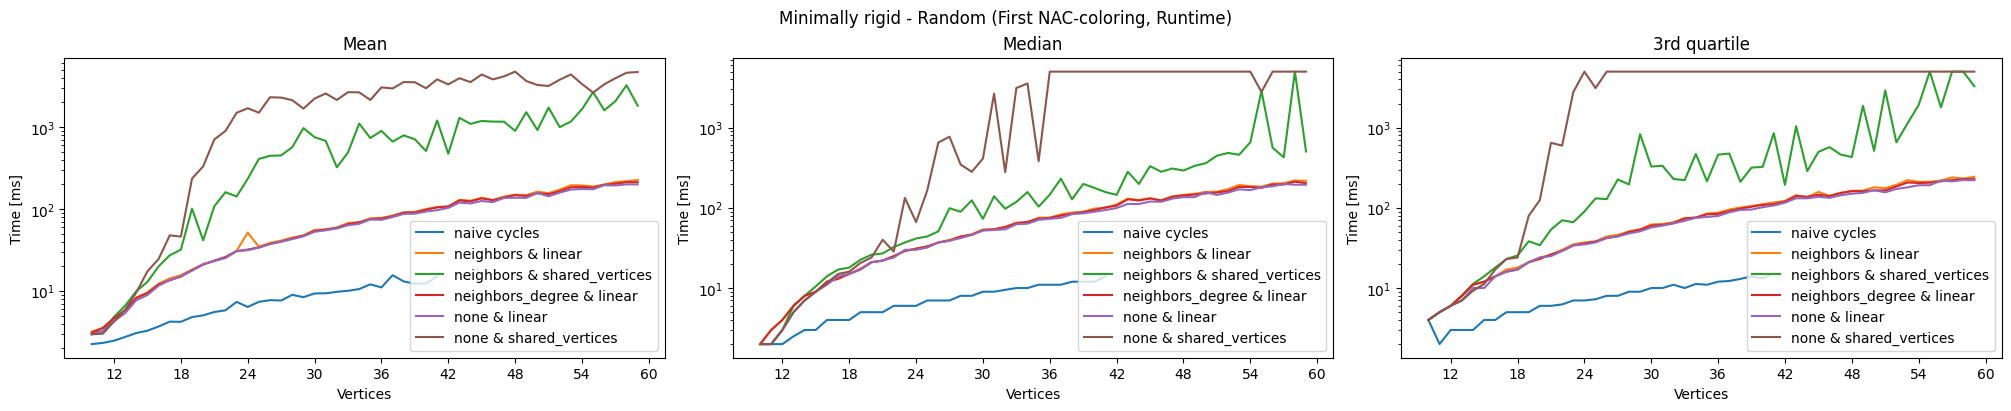

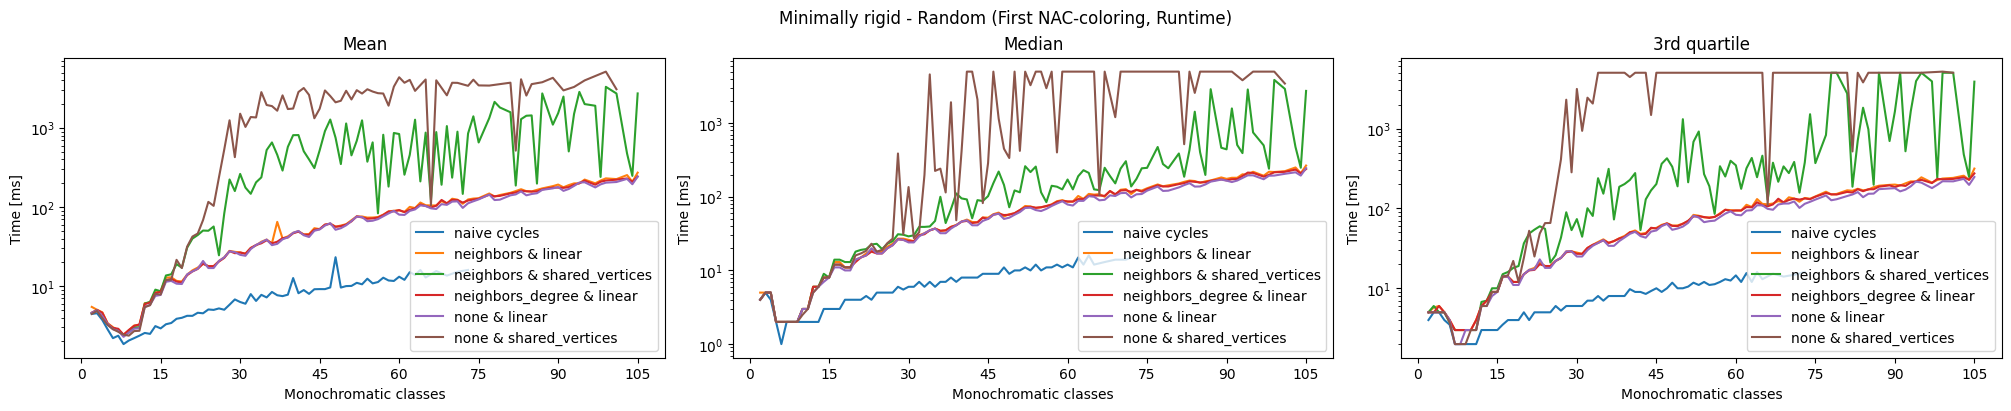

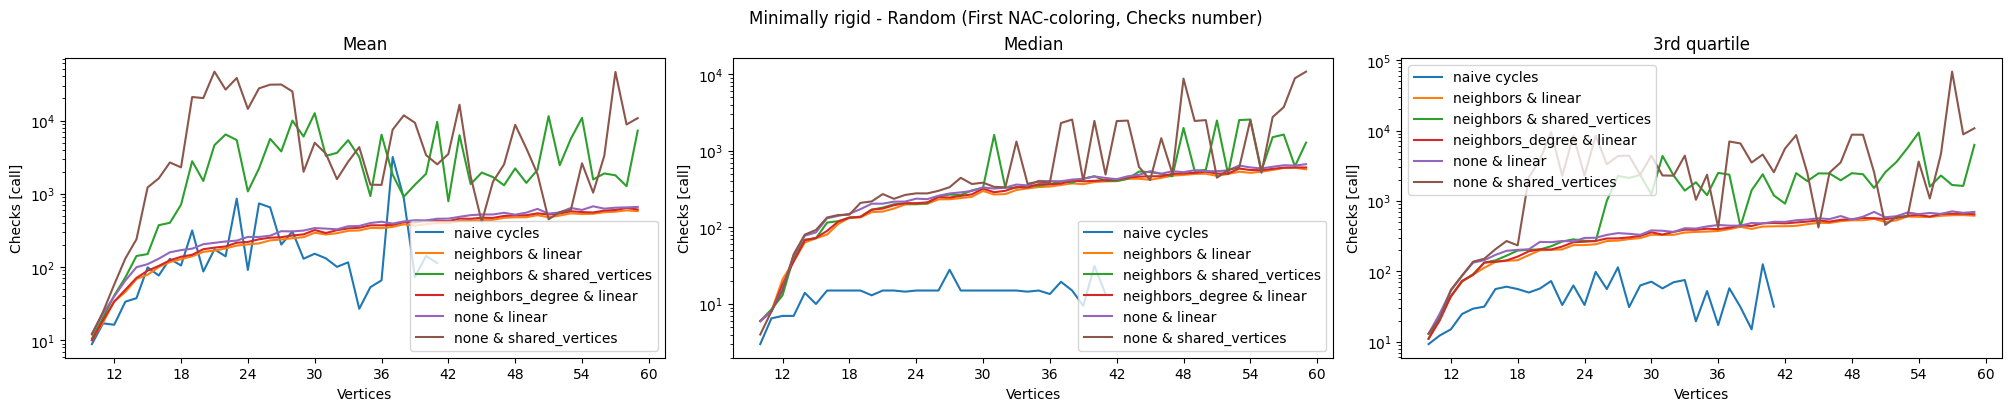

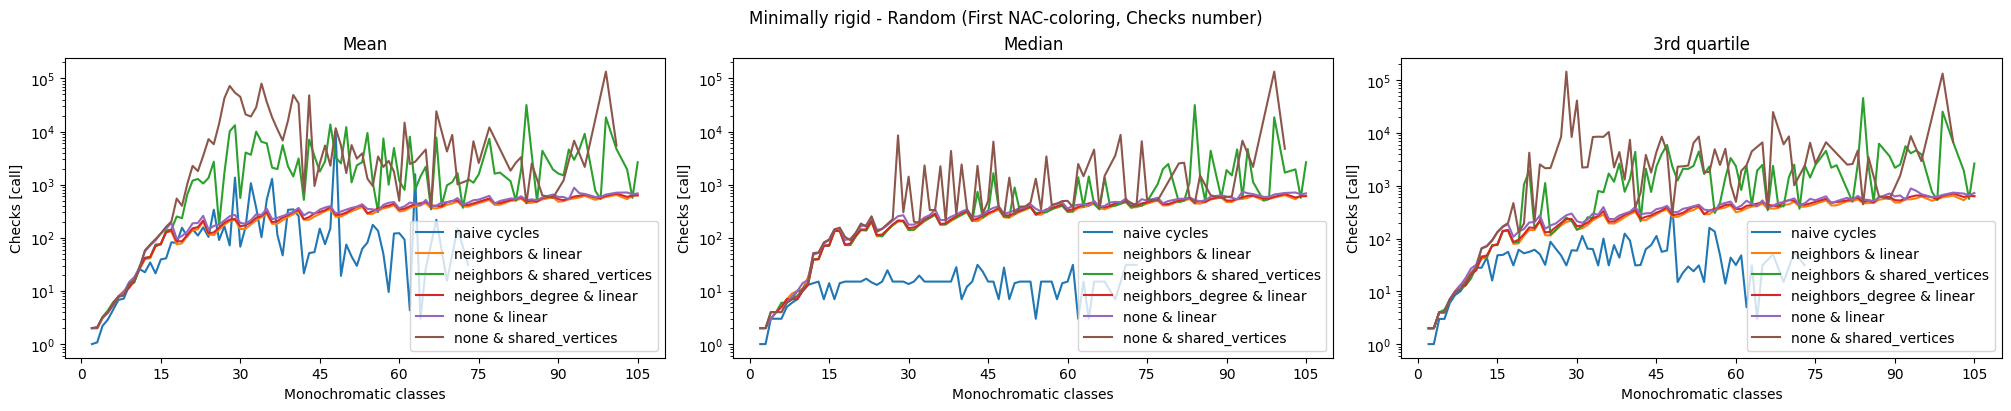

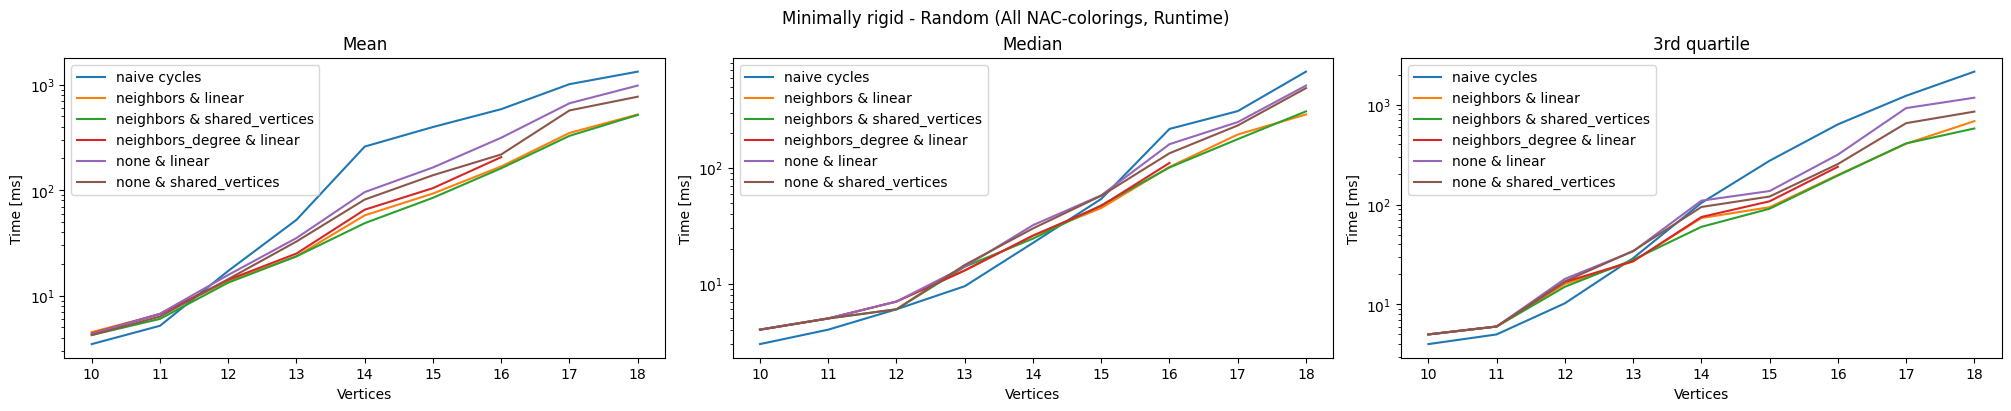

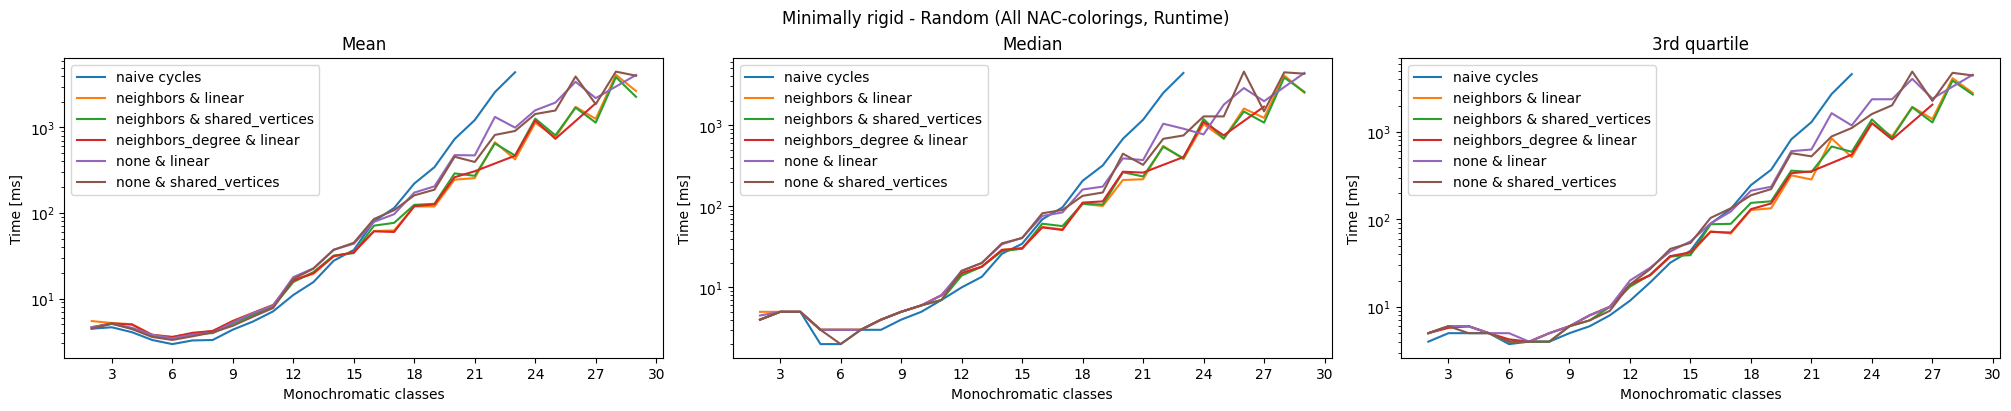

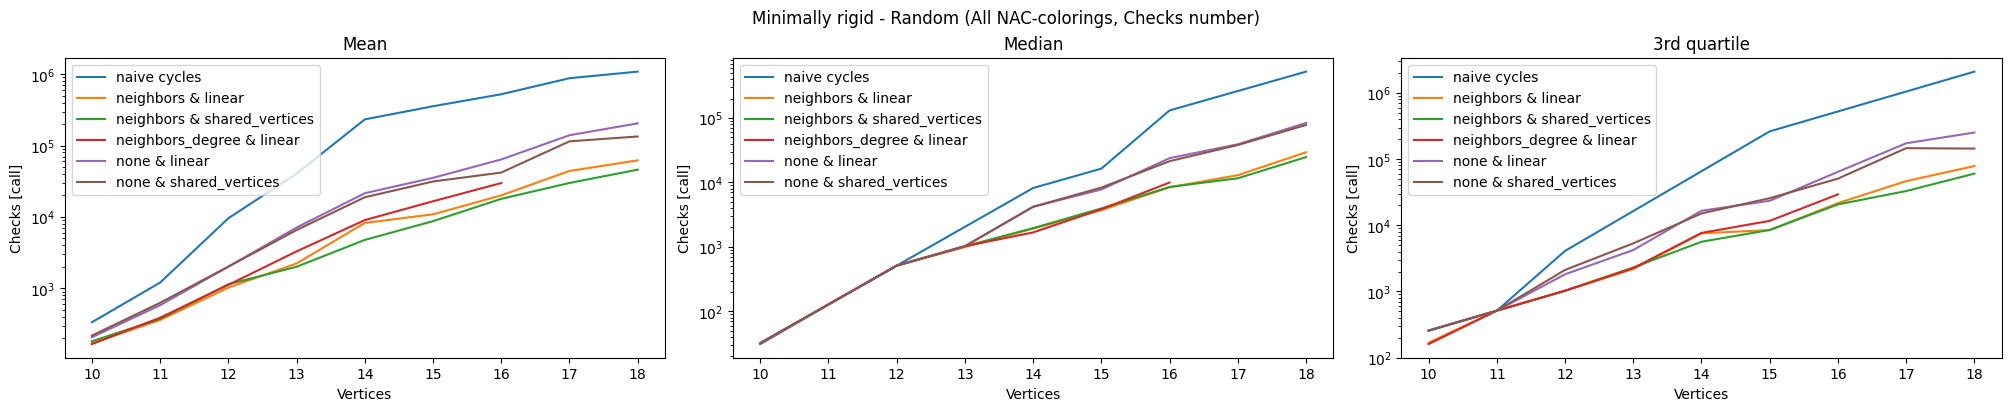

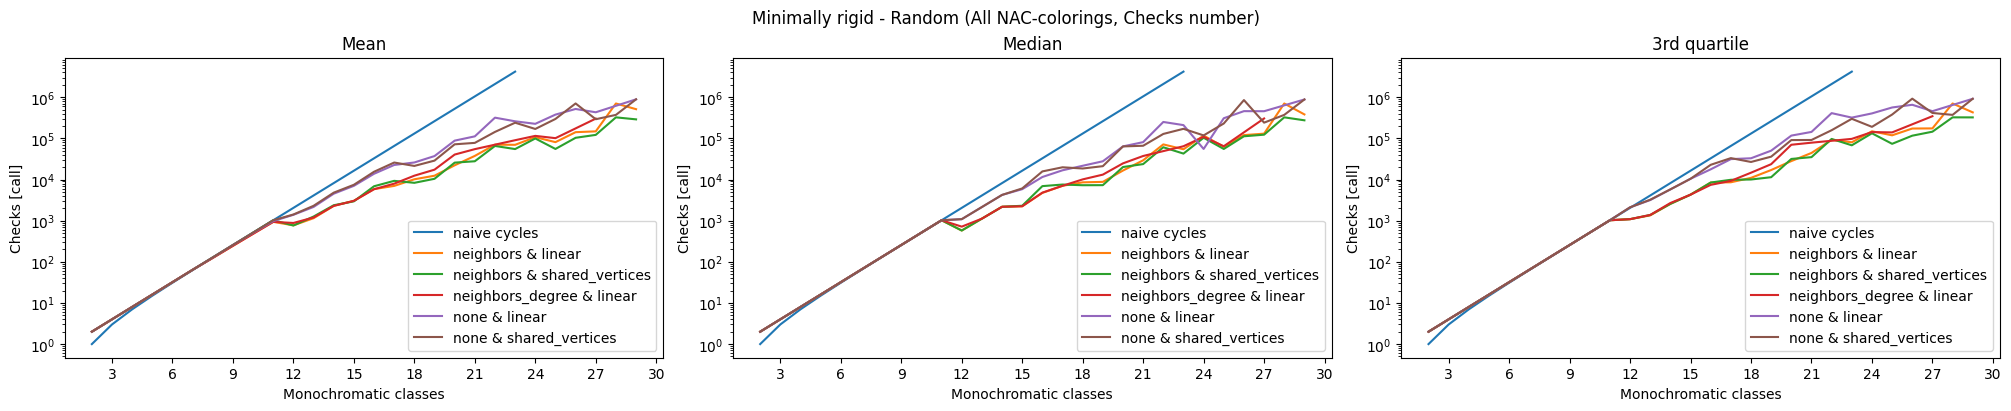

In [18]:
if True:
    [display(fig) for fig in plot_frame("Minimally rigid - Random", df_analytics.query("dataset == 'laman_random'"))]

### No 3 nor 4 cycles

Graphs with no 3 nor 4 cycles up to 42 vertices

Plotting 6684 records and 576 graphs...


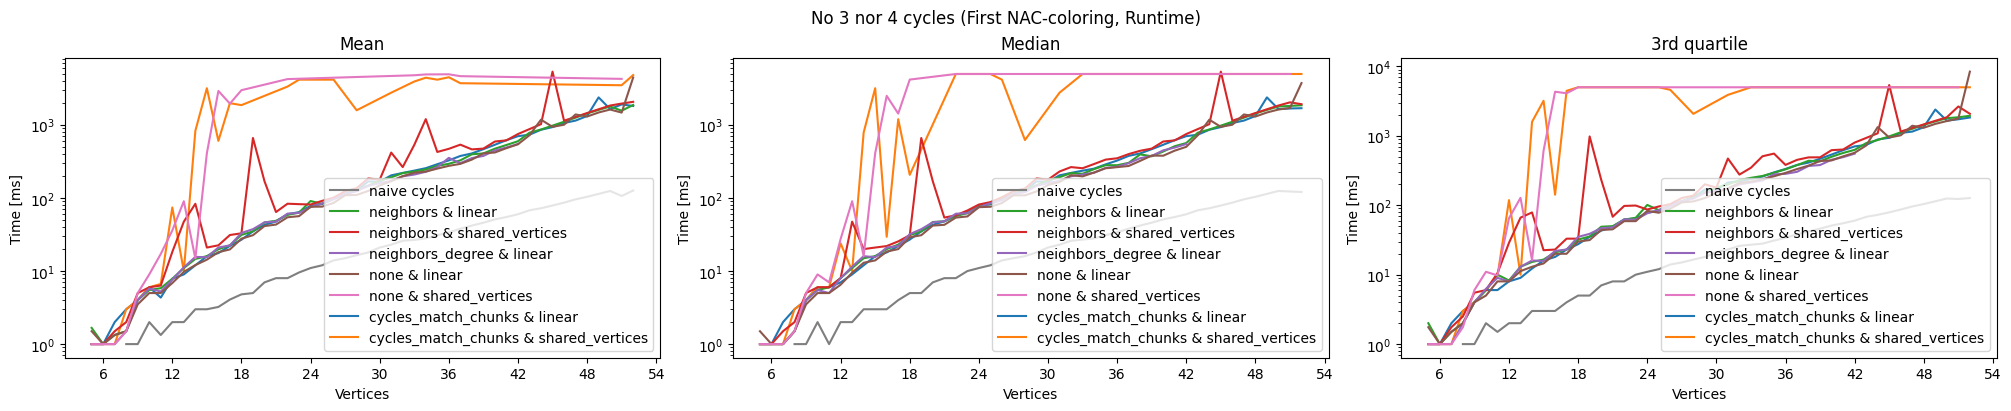

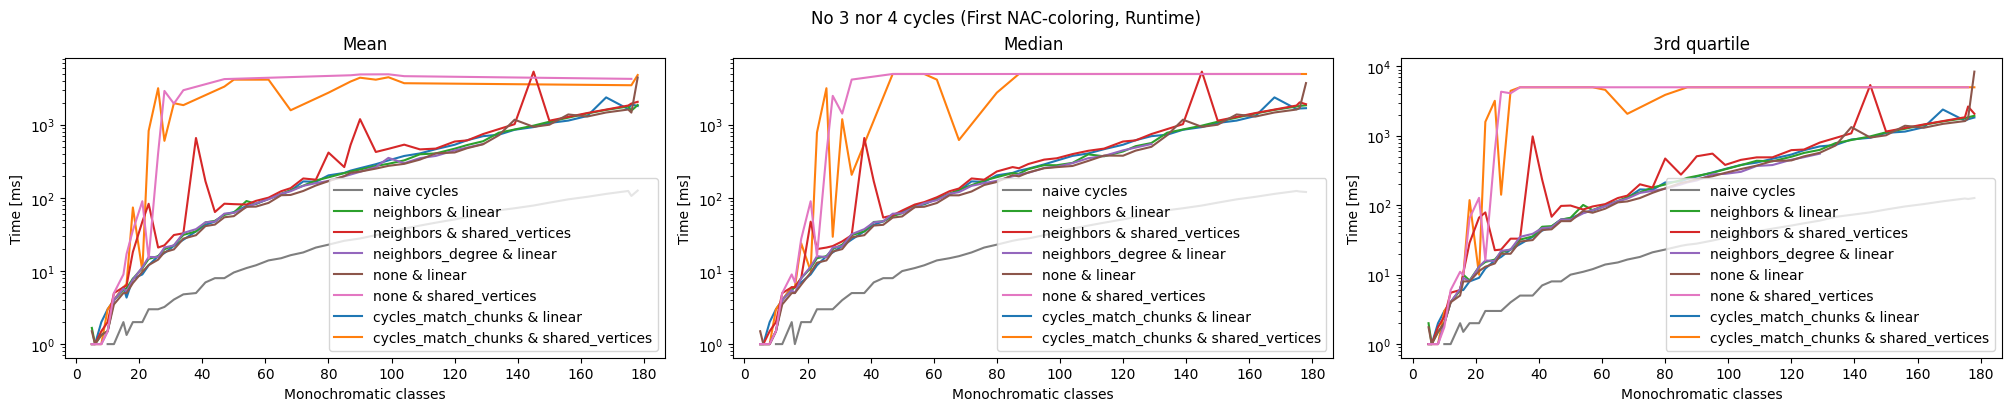

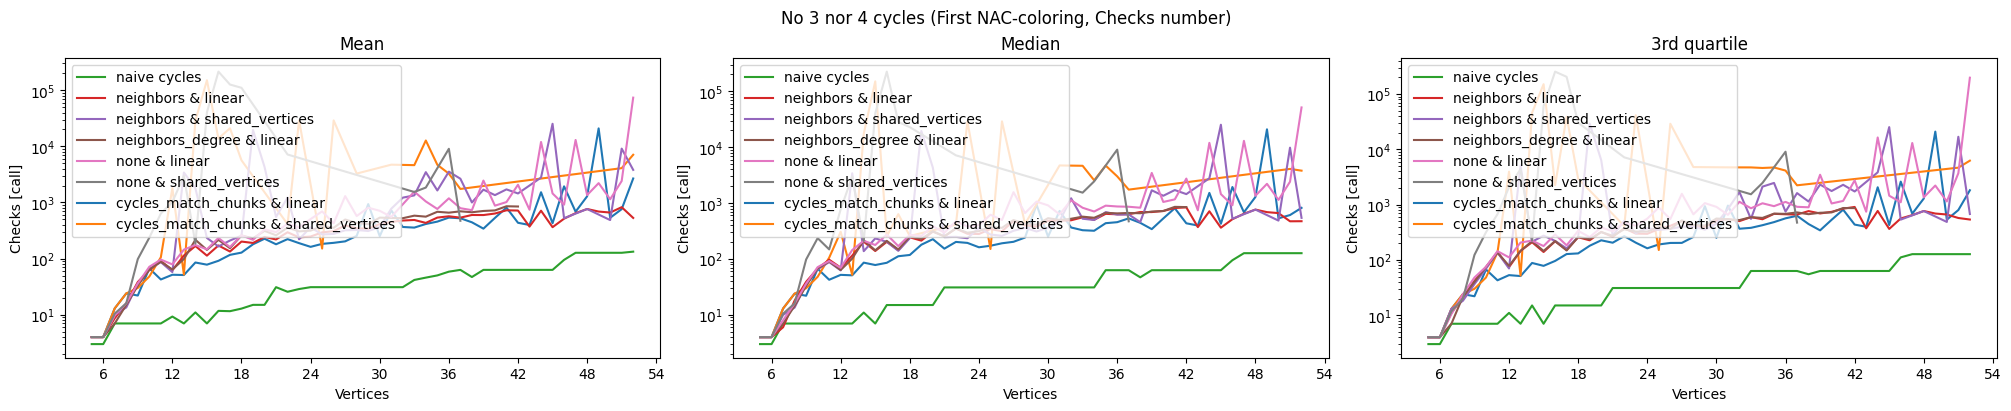

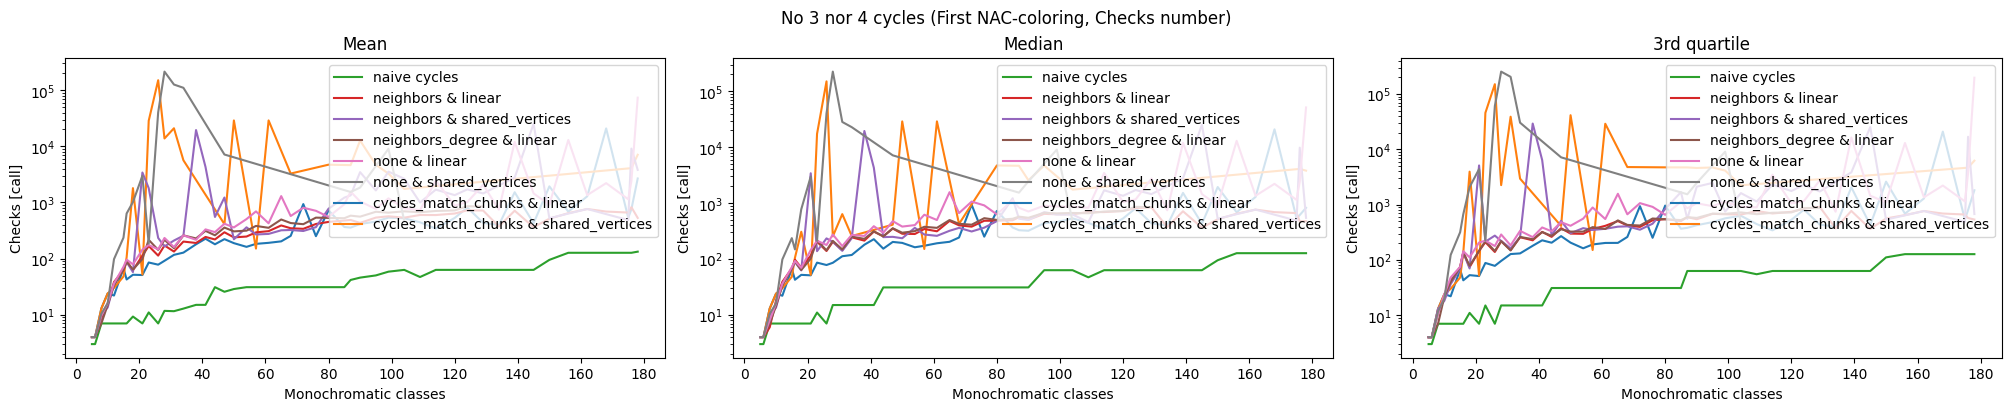

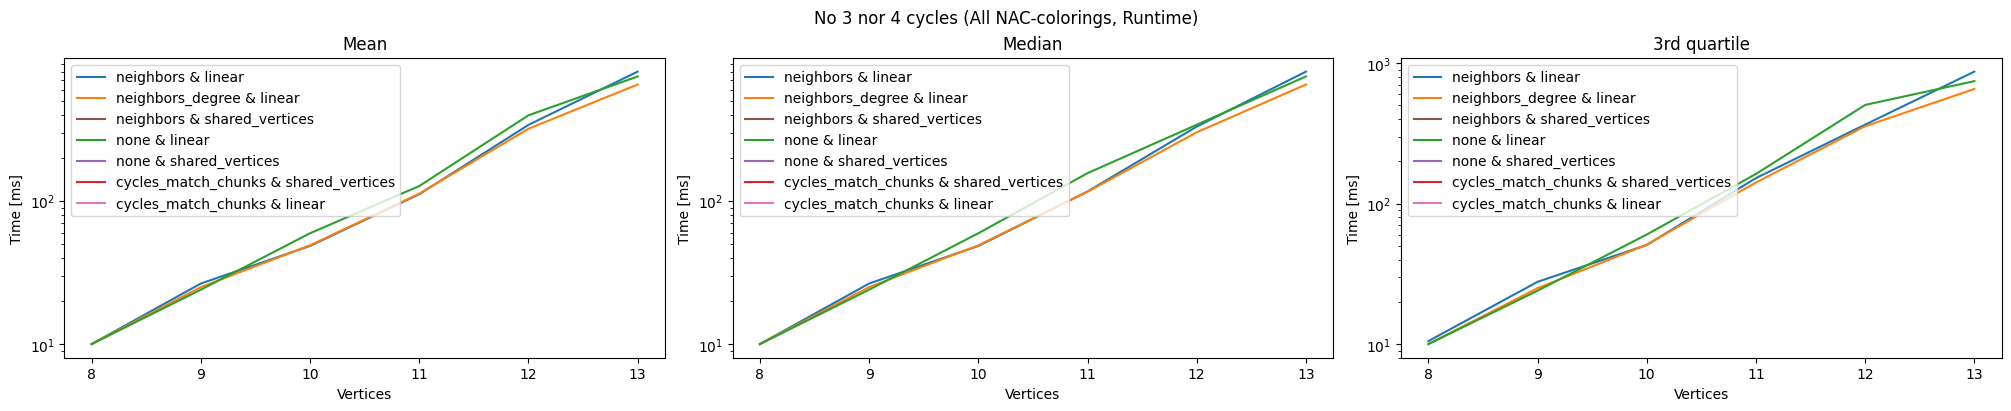

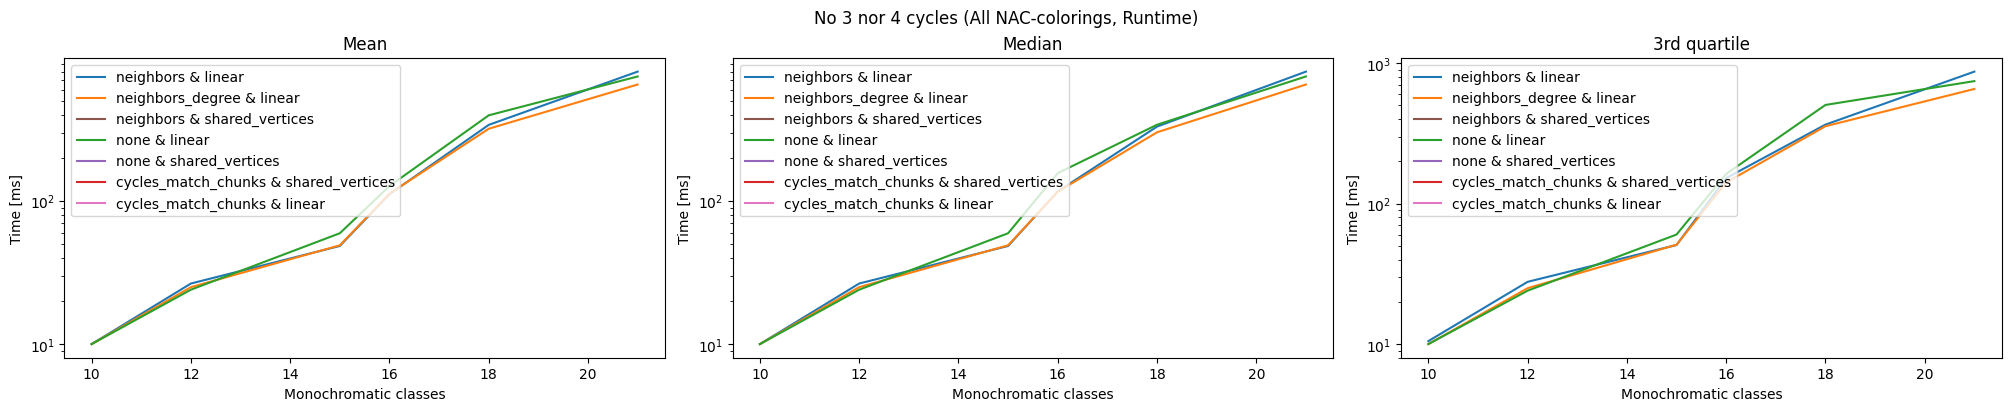

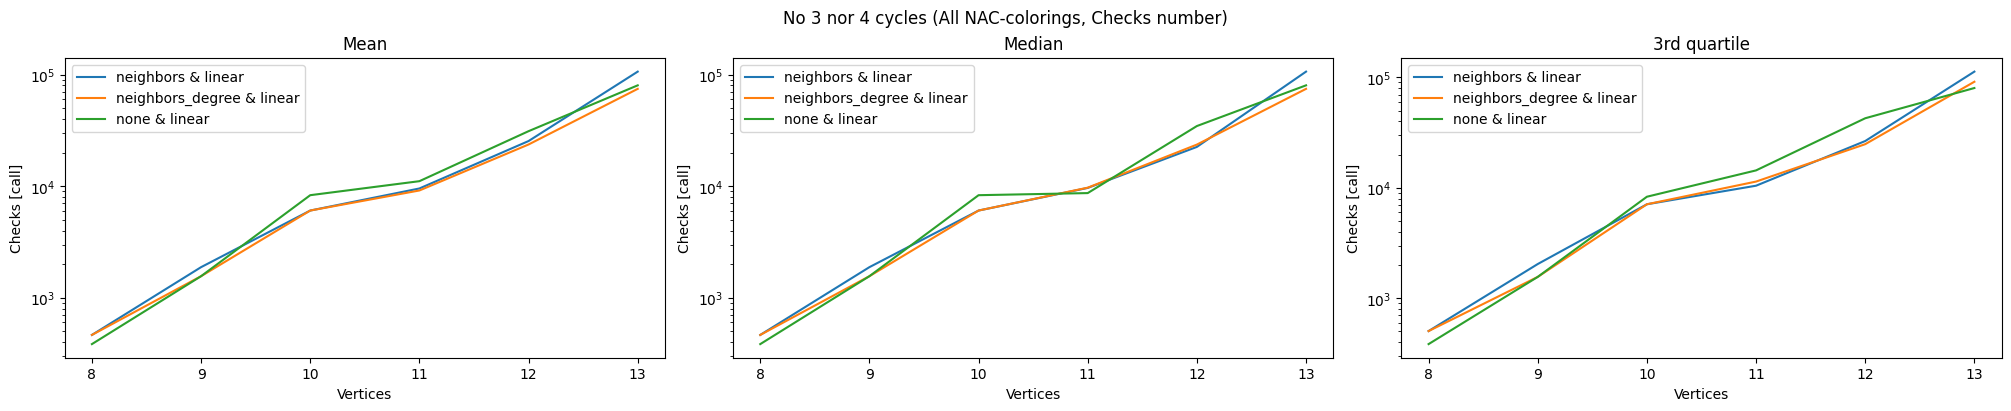

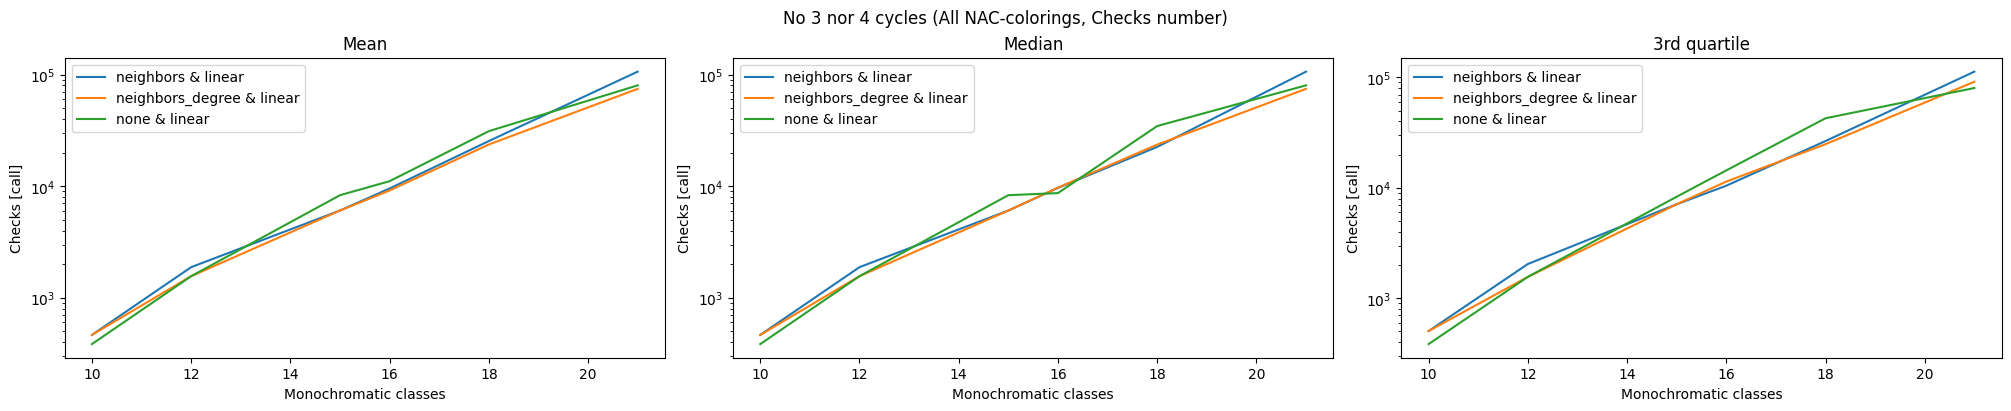

In [19]:
if True:
    [display(fig) for fig in plot_frame("No 3 nor 4 cycles", df_analytics.query("dataset == 'no_3_nor_4_cycles'"))]

### Graphs with few NAC-colorings

Graphs generated according to yet unpublished formula that guaranties that these graphs should either have none or small number of NAC-colorings.

Plotting 32037 records and 5974 graphs...


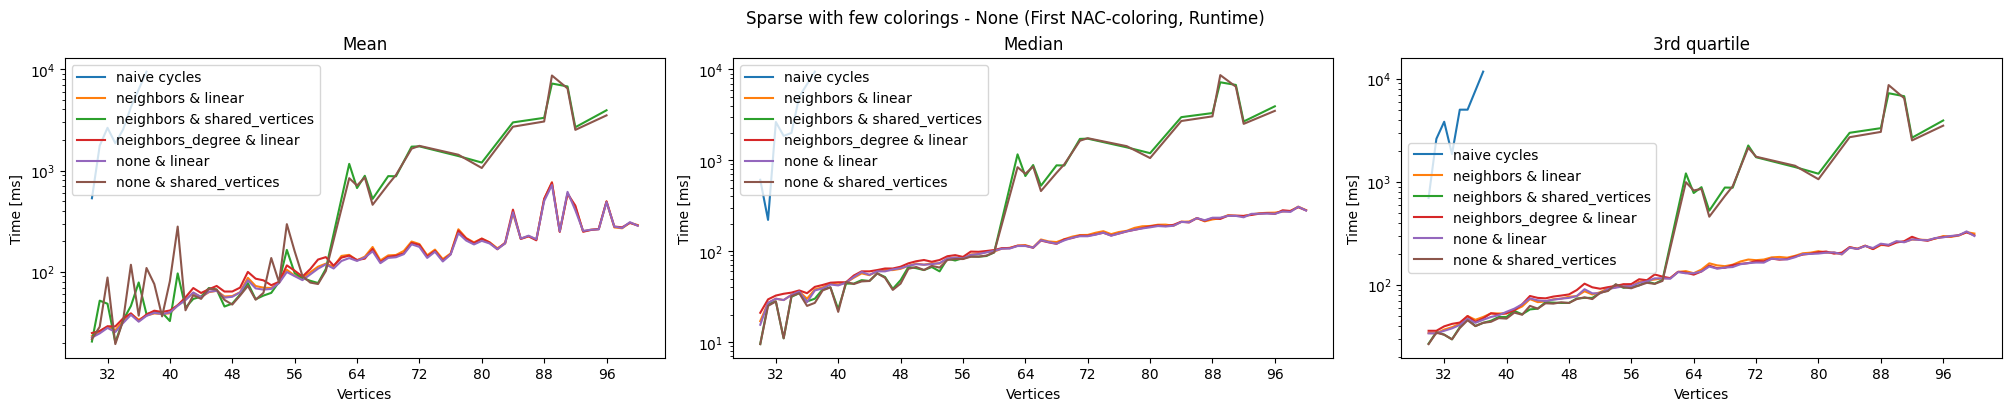

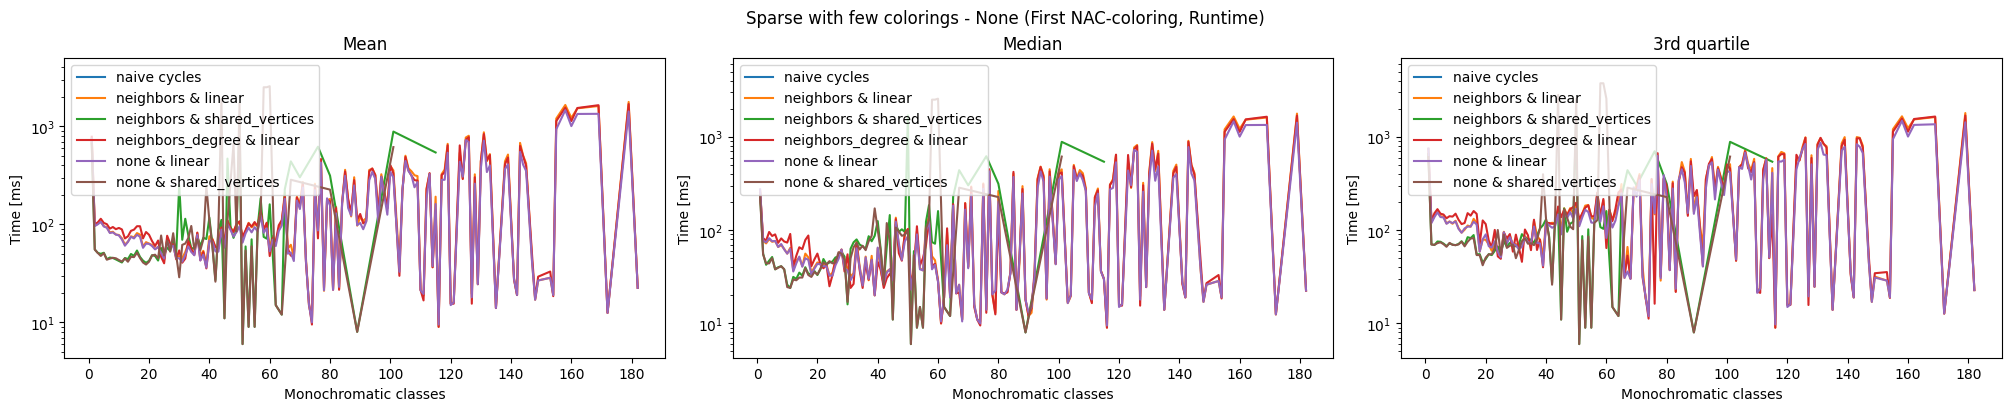

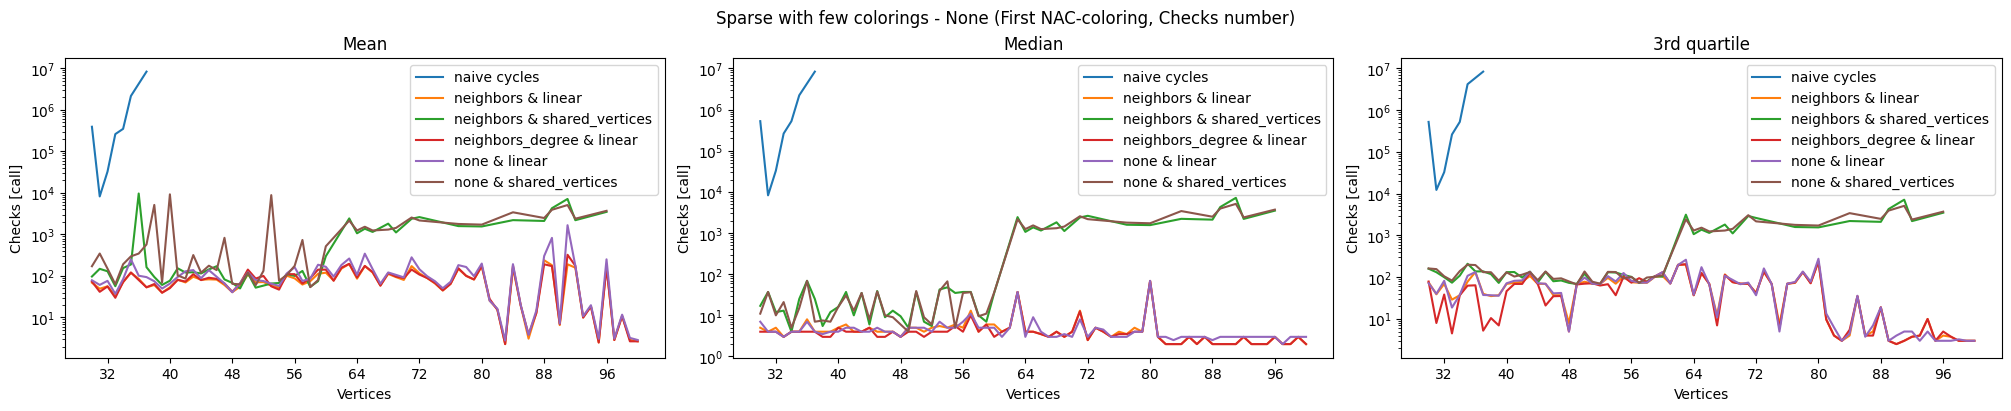

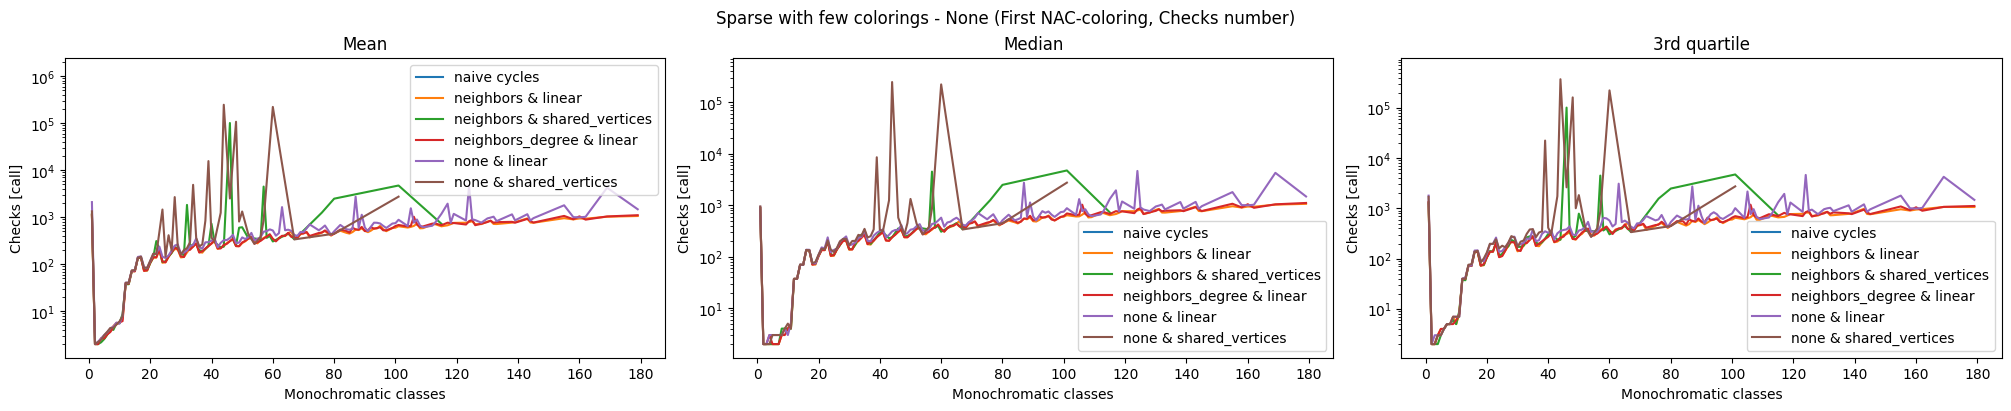

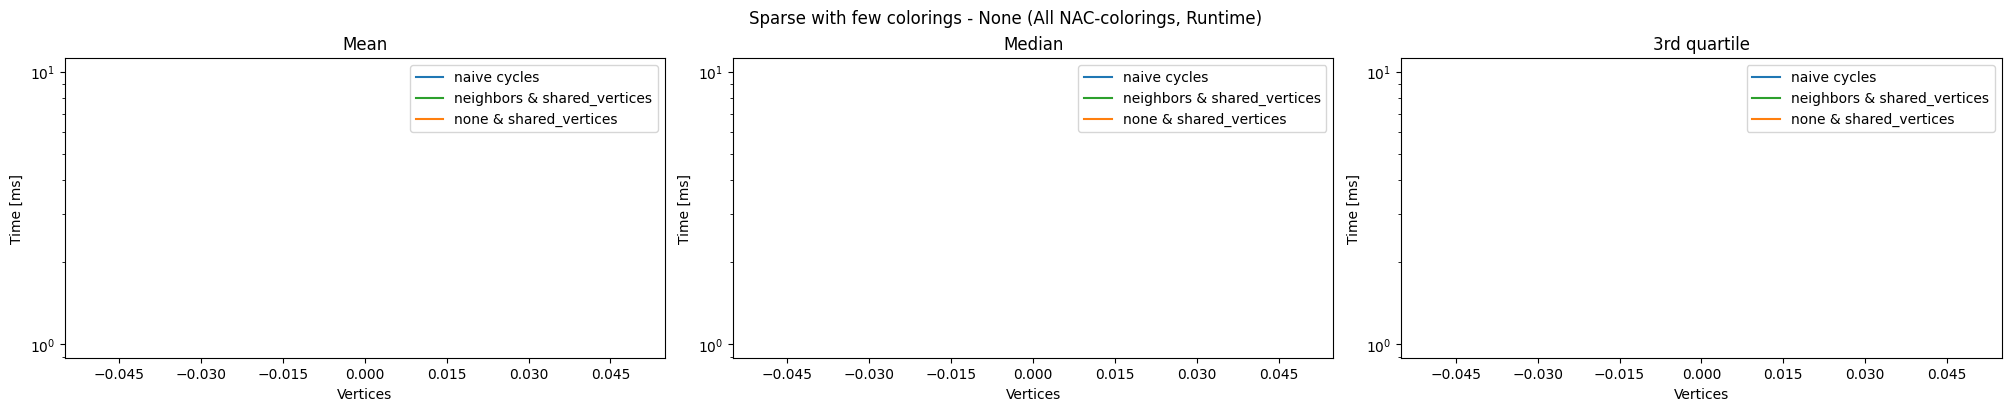

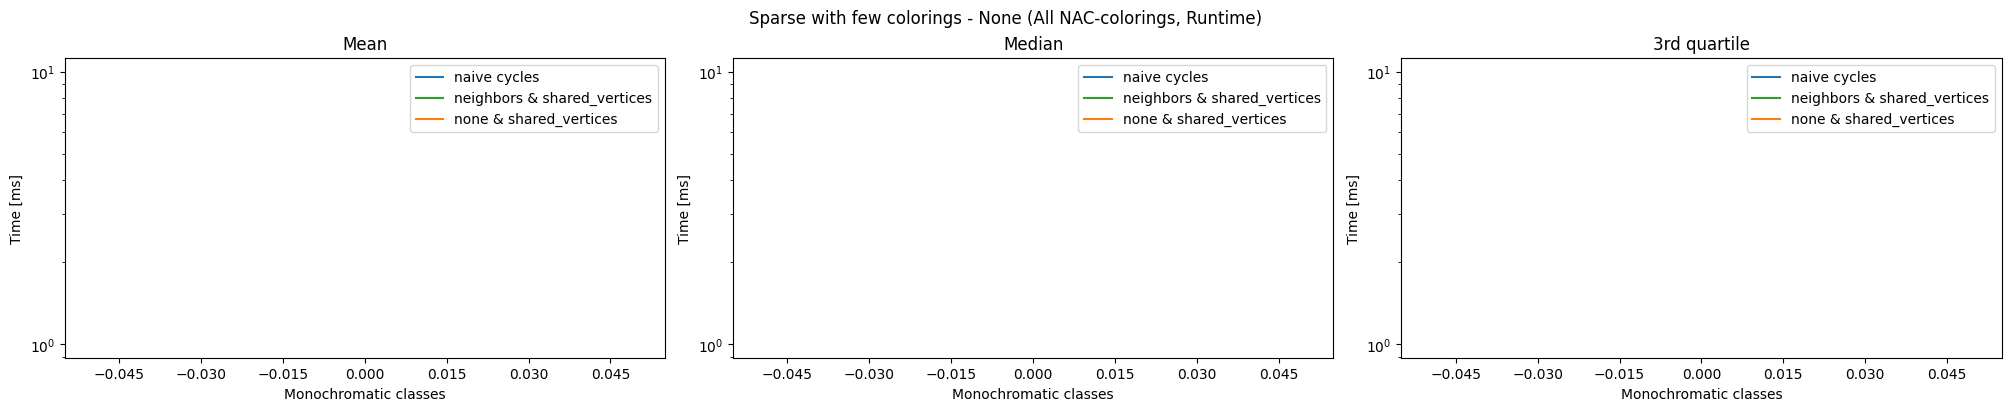

In [20]:
if True:
    [display(fig) for fig in plot_frame("Sparse with few colorings - None", df_analytics.query("dataset == 'few_colorings'"))]

### Globally rigid graphs

Randomly generated globally rigid graphs

Plotting 49651 records and 4691 graphs...


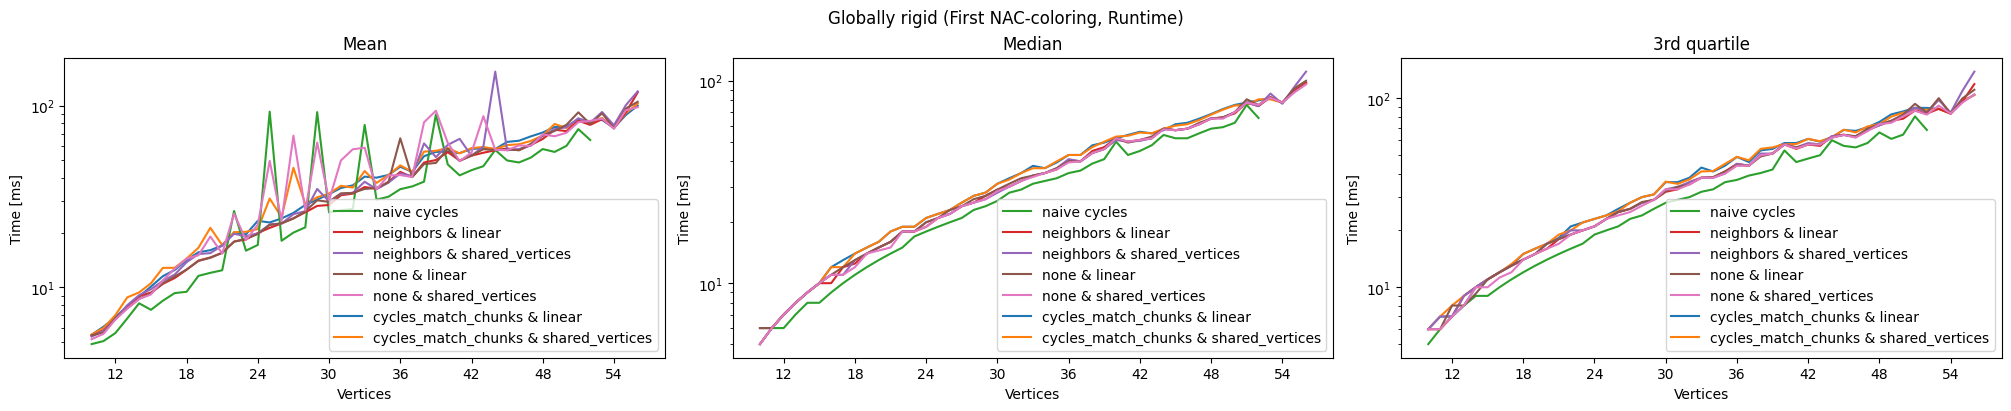

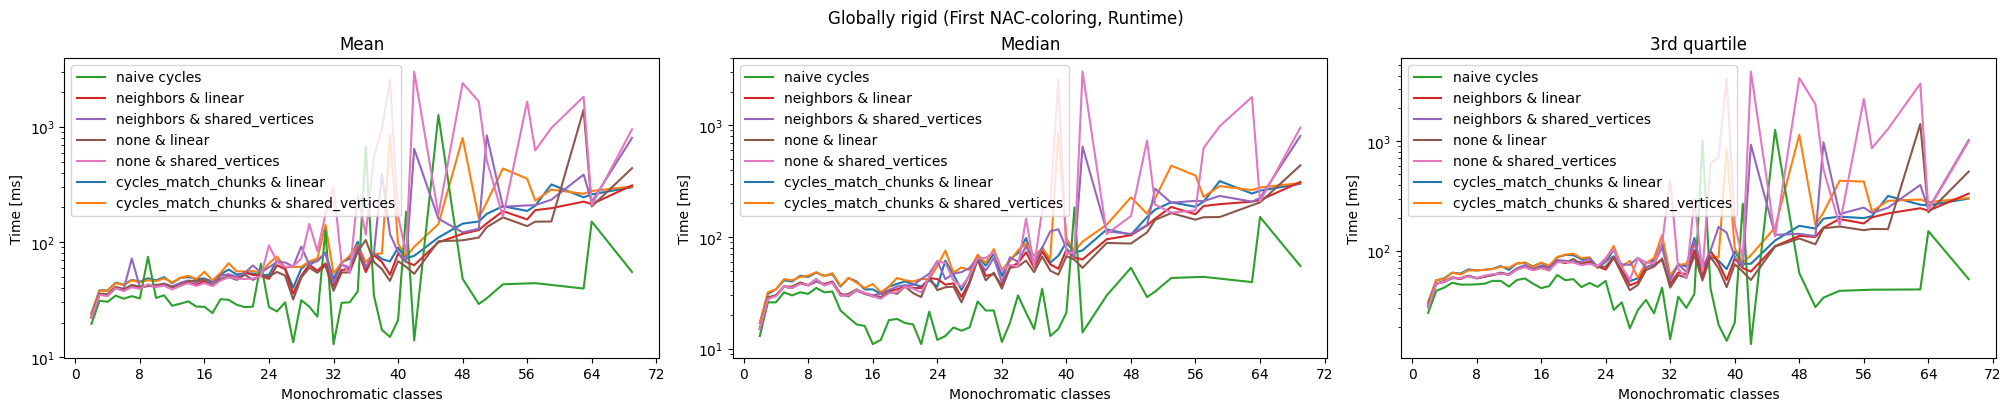

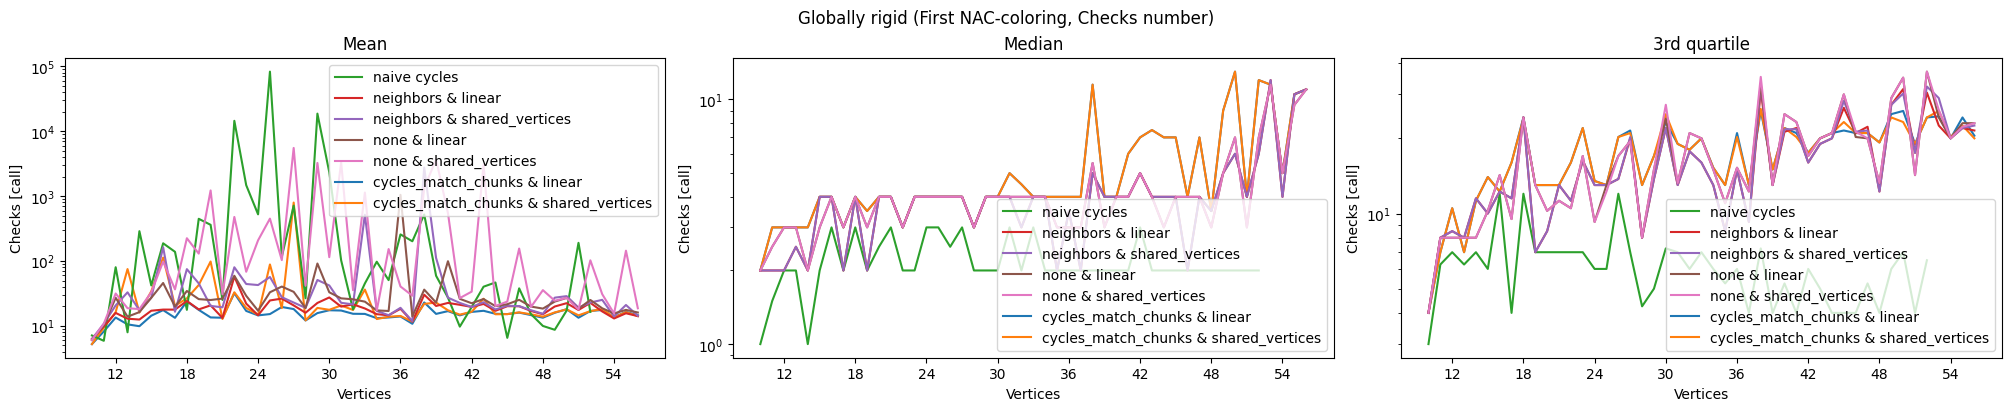

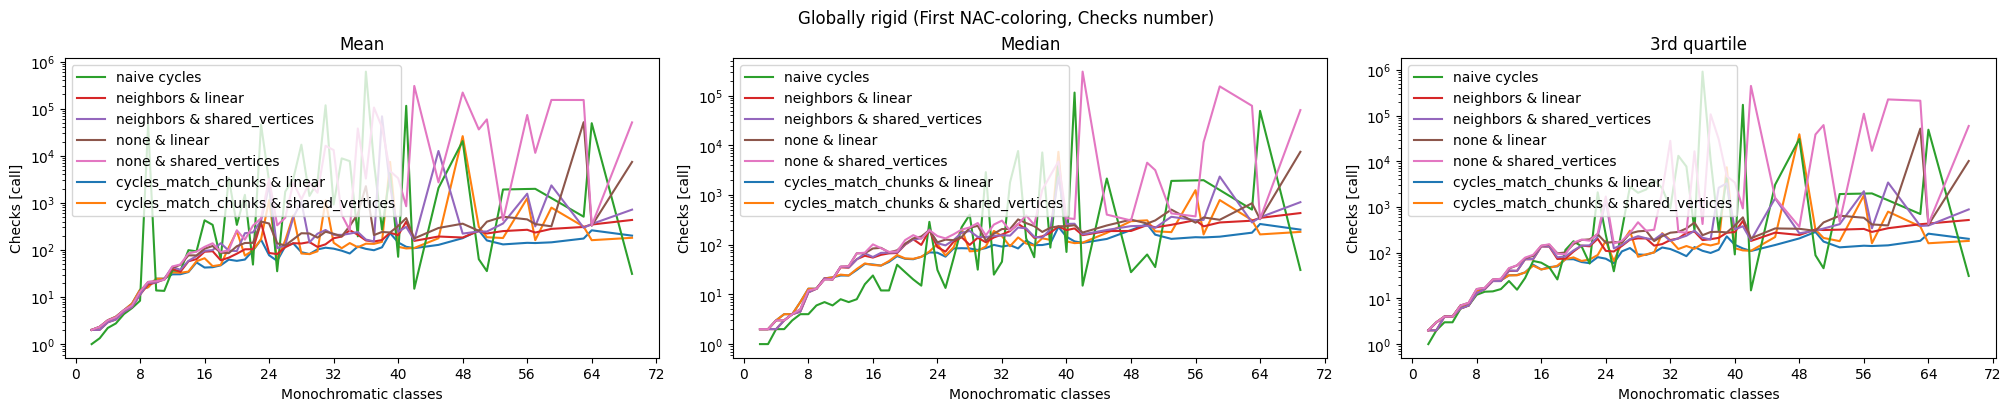

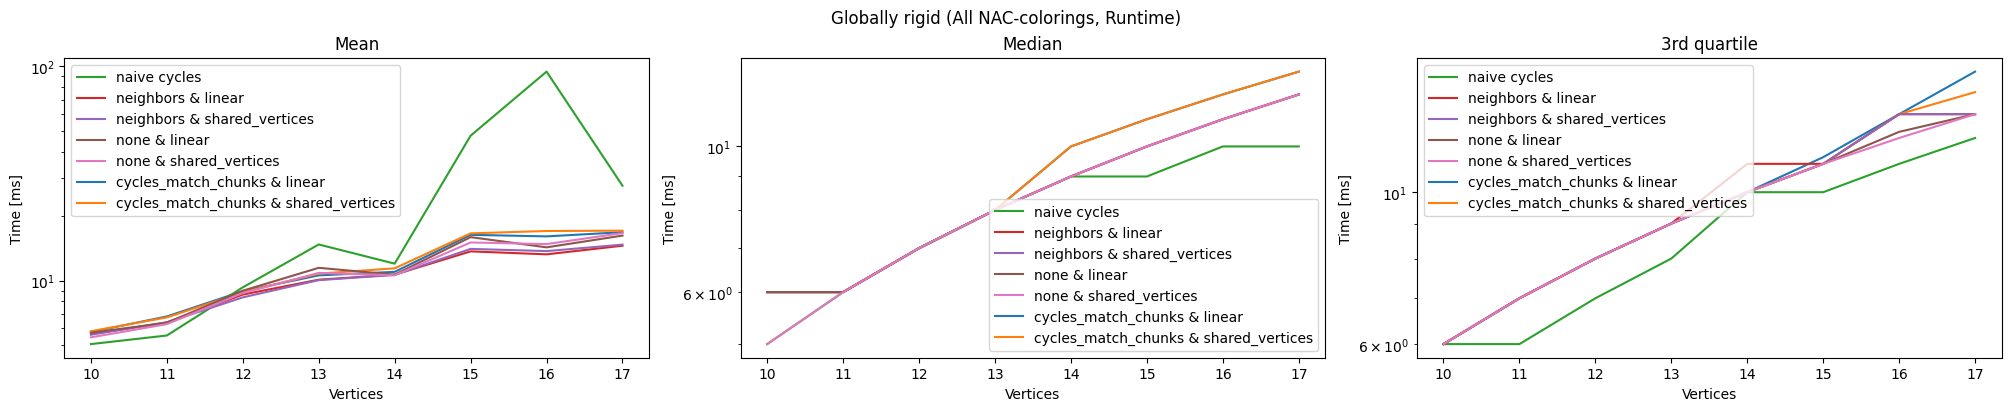

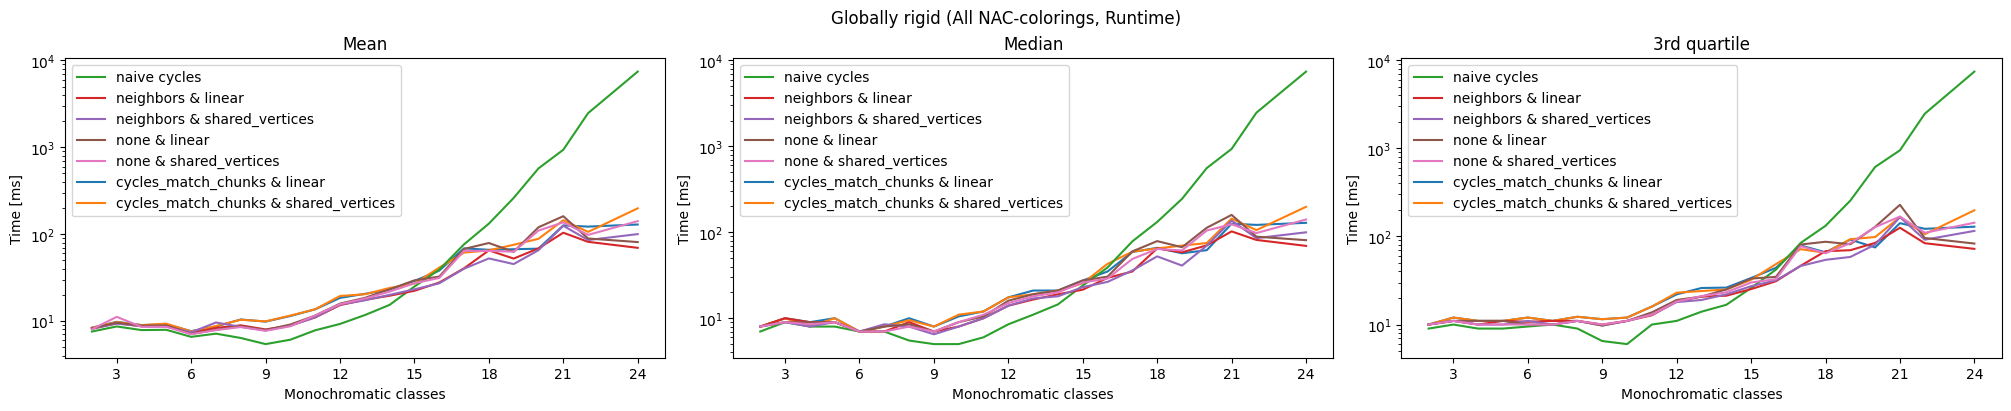

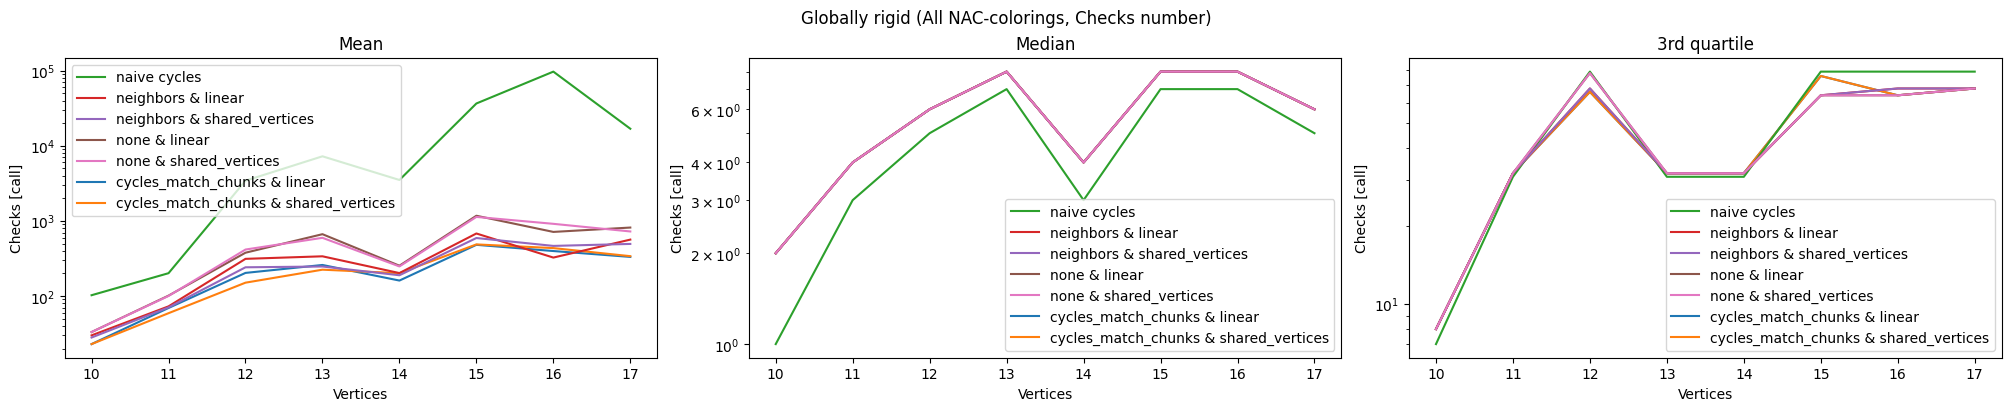

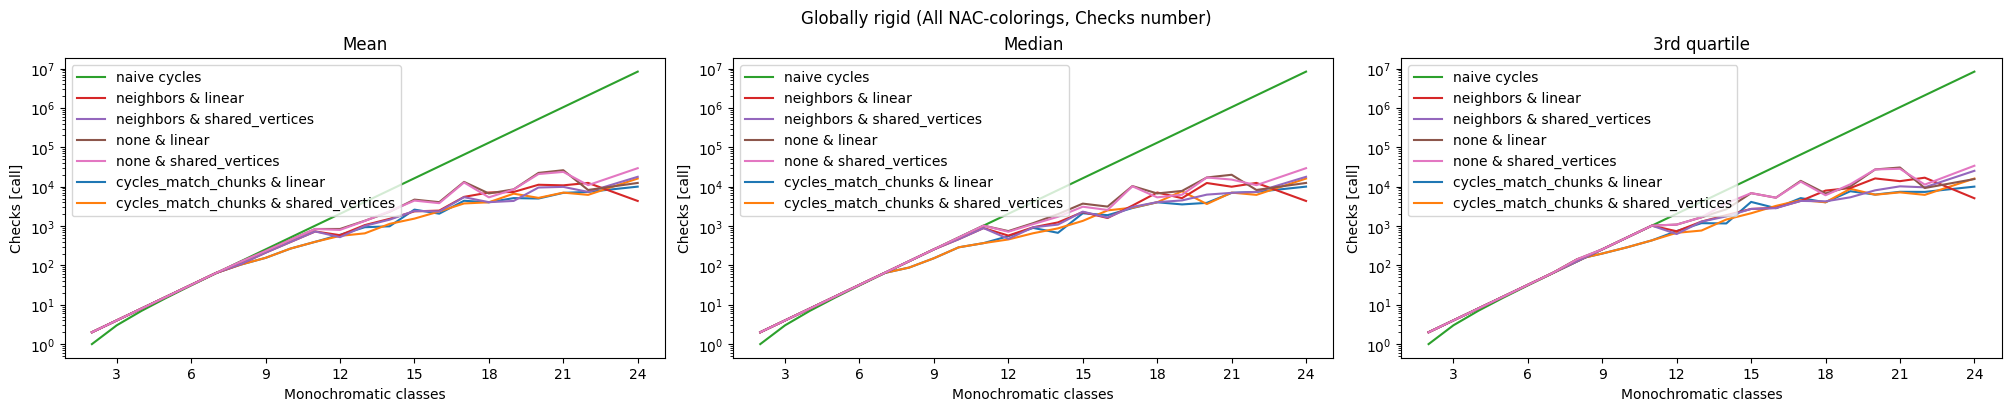

In [21]:
if True:
    [display(fig) for fig in plot_frame("Globally rigid", df_analytics.query("dataset == 'globally_rigid'"))]

### No NAC-coloring

Random graphs that we found that have no NAC-coloring and more than one triangle-connected component

In [22]:
def query_no_nac_coloring_generated(base: pd.DataFrame) -> pd.DataFrame:
    base = base.reset_index(inplace=False)
    base_40 = base.query("dataset == 'no_nac_coloring_generated_40'")
    base_50 = base.query("dataset == 'no_nac_coloring_generated_50'")
    base_60 = base.query("dataset == 'no_nac_coloring_generated_60'")
    base_70 = base.query("dataset == 'no_nac_coloring_generated_70'")
    base_80 = base.query("dataset == 'no_nac_coloring_generated_80'")
    base_90 = base.query("dataset == 'no_nac_coloring_generated_90'")
    base_100 = base.query("dataset == 'no_nac_coloring_generated_100'")
    base_110 = base.query("dataset == 'no_nac_coloring_generated_110'")
    base_120 = base.query("dataset == 'no_nac_coloring_generated_120'")
    base_130 = base.query("dataset == 'no_nac_coloring_generated_130'")
    # df = base_40
    df = pd.concat([base_40, base_50, base_60, base_70, base_80, base_90, base_100, base_110, base_120, base_130], ignore_index=True)
    df.set_index("graph", inplace=True)
    return df

Plotting 122658 records and 5000 graphs...


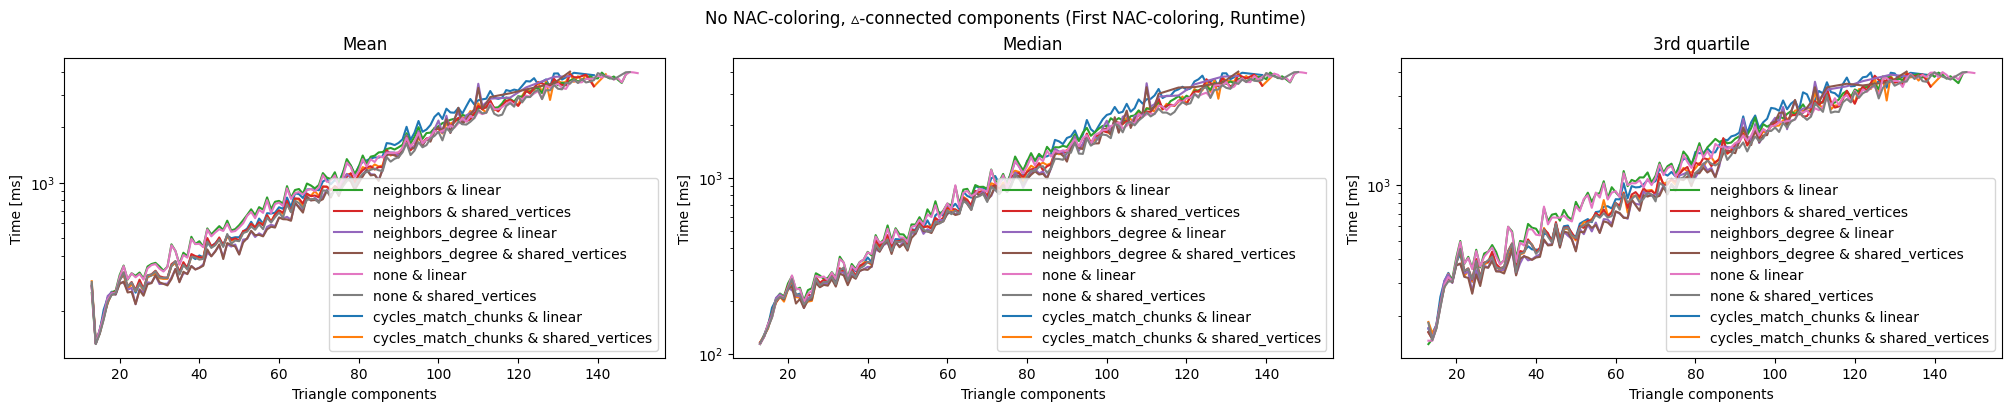

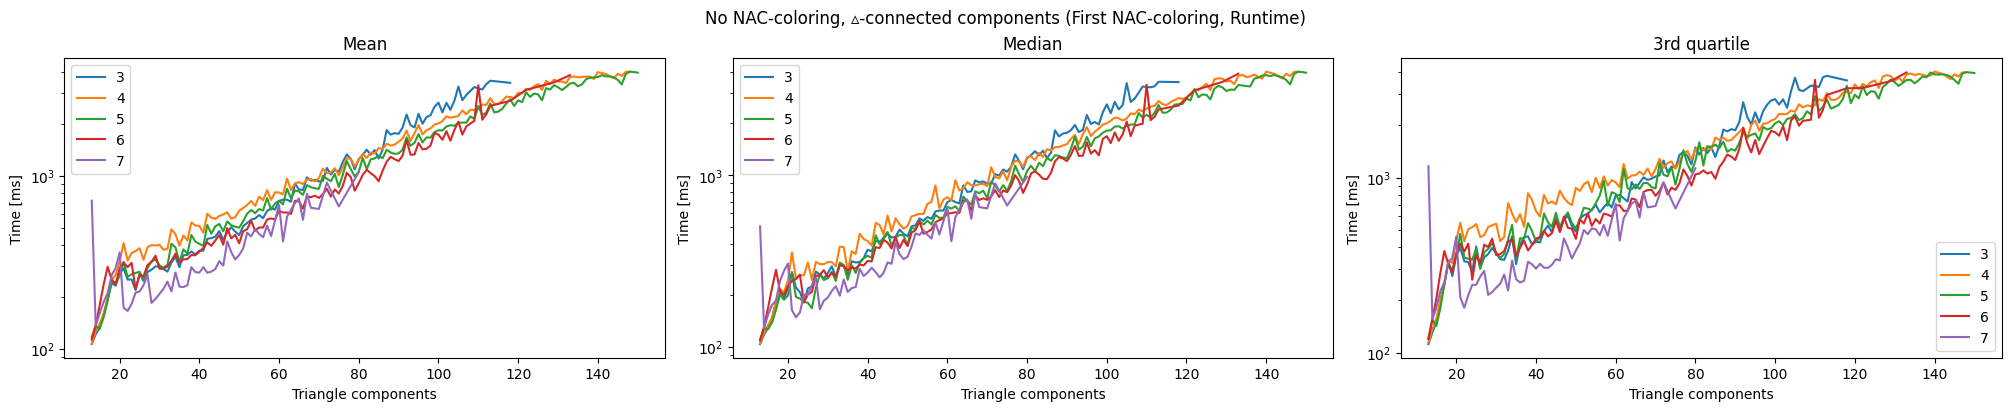

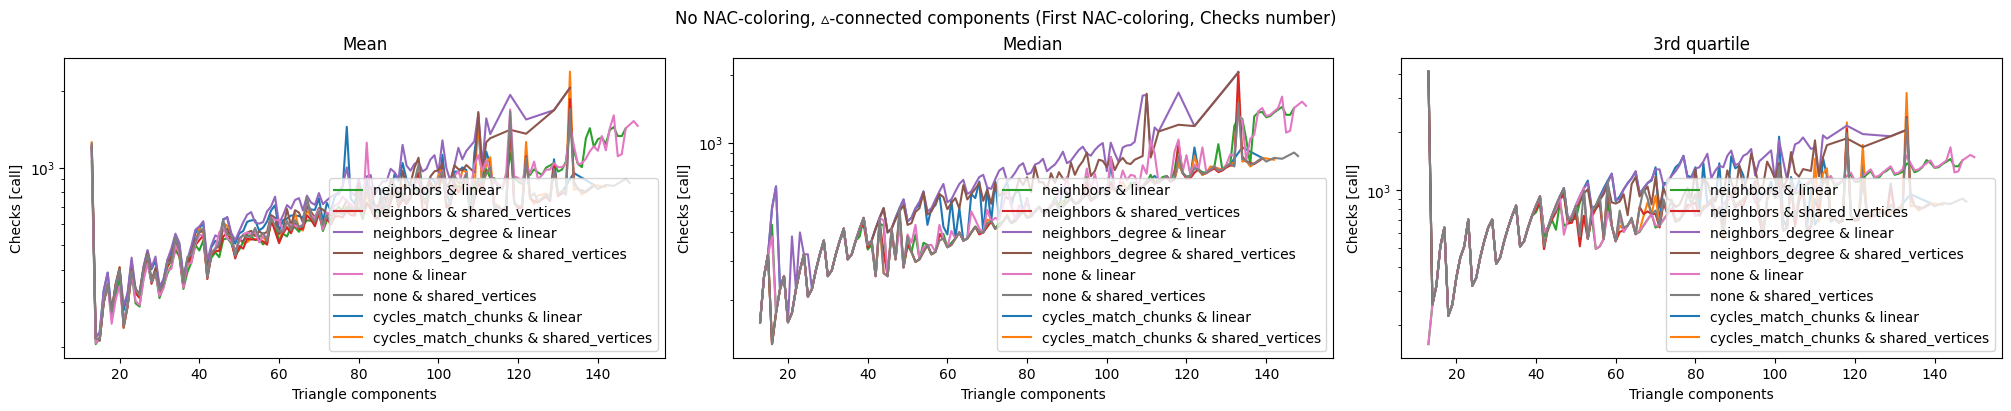

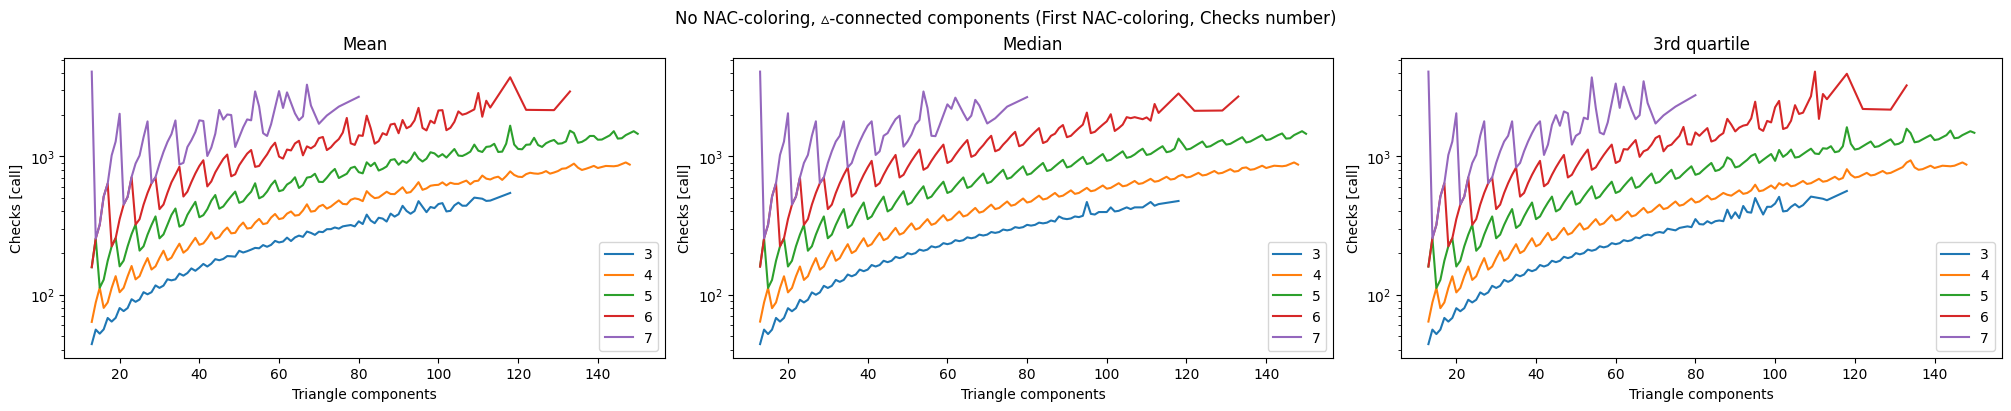

In [23]:
if True:
    base = df_analytics_no_nac.query("merging!='naive-cycles' and merging!='min_max' and merging!='sorted_bits' and split!='neighbors_iterative' and split!='beam_neighbors'")
    df = query_no_nac_coloring_generated(base)
    df = drop_outliers(df)
    title = 'No NAC-coloring, ▵-connected components'
    dataset_name = 'no_nac_coloring_generated'
    figs = [fig for fig in plot_frame(
        title,
        df.query("merging != 'sorted_size'"),
        ops_x_column=["triangle_components_no",], # "vertex_no",
        ops_based_on=["split_merging", "subgraph_size",],
    )]
    [display(fig) for fig in figs]

## The number of checks needed

This group of graphs compares the number of checks performed by our algorithm and by naive algorithm
using either no monochromatic classes, triangle components or monochromatic classes described in the article.

Unless you change anything, the result is plotted from the whole benchmarks dataset - all the graphs classes are used.
You can add `query("dataset == '...'")` to show the graph for a specific dataset.

The number of `IsNACColoring` checks called compared to
the naive approach without or with triangle/monochromatic classes.

It is expected that the number of `IsNACColoring` checks will be smaller than the `CycleMask` checks as the `CycleMask` checks happen every time, but `IsNACColoring` checks happen only if the previous checks fail.

Plotting 32816 records...


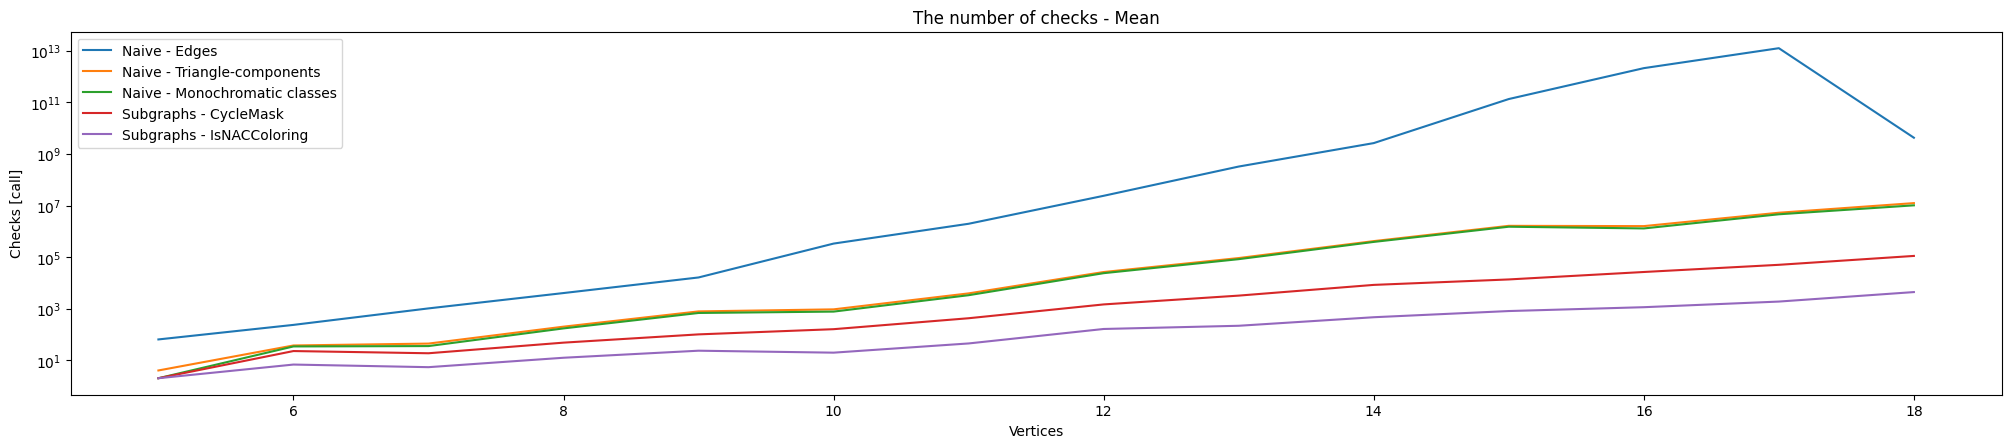

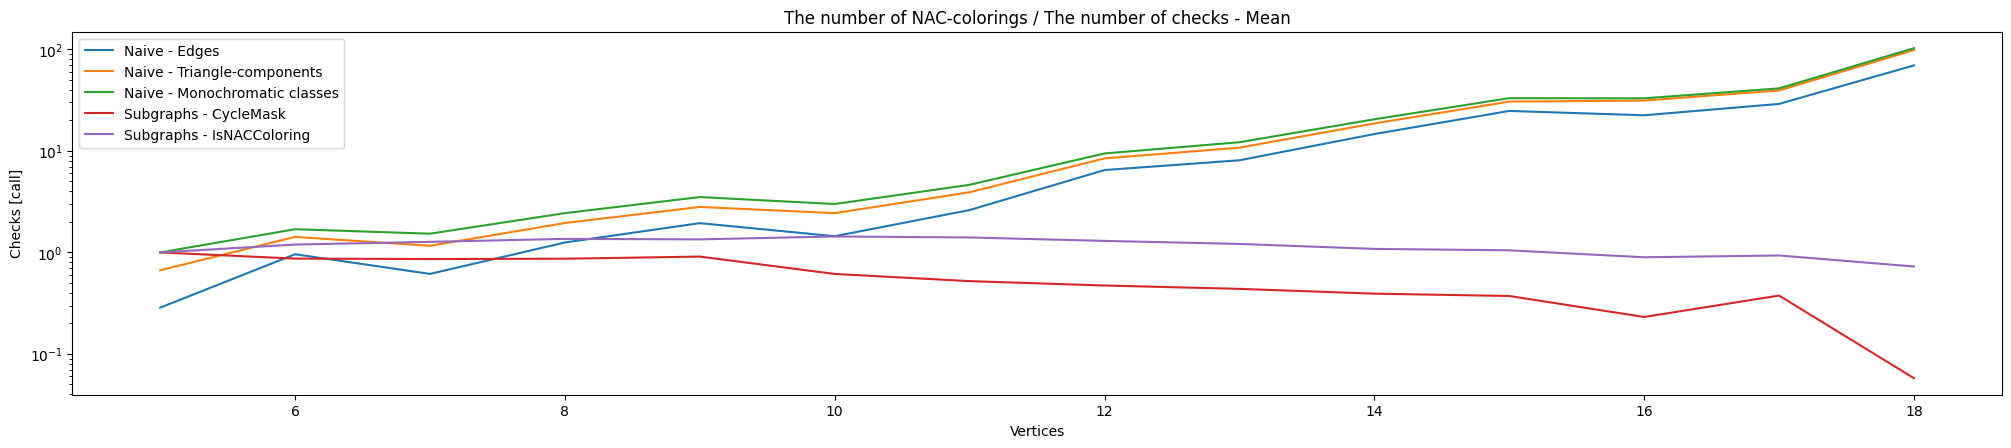

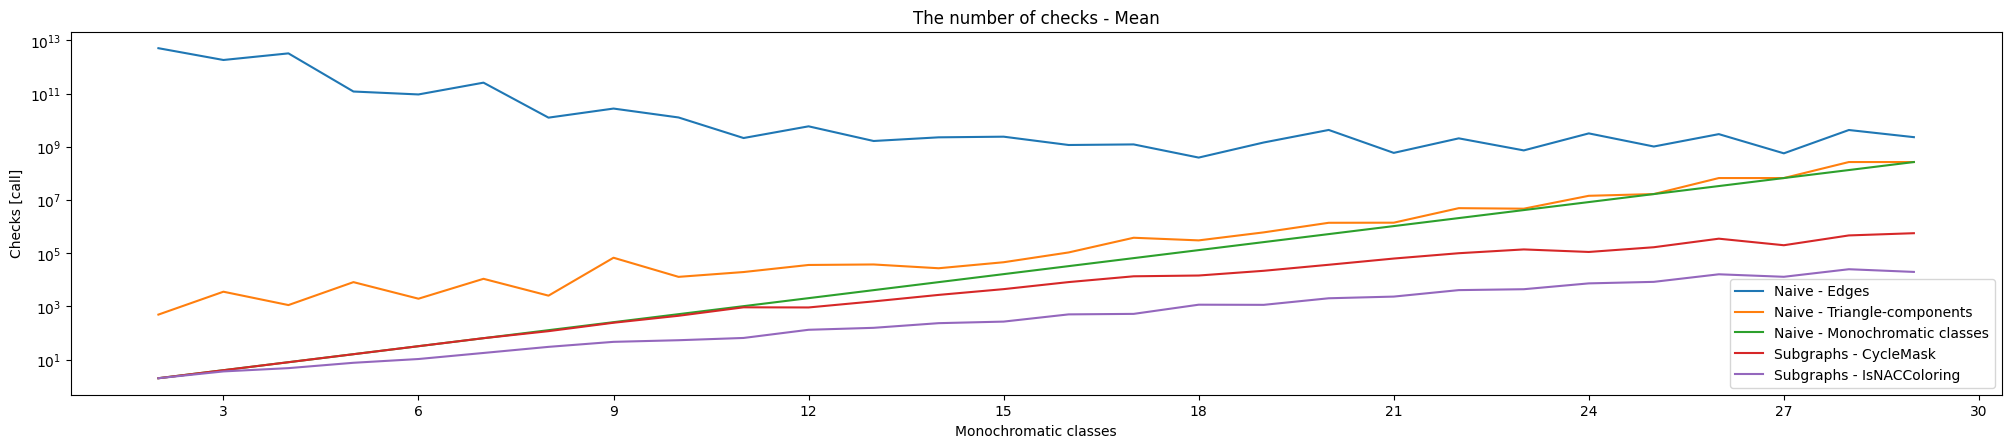

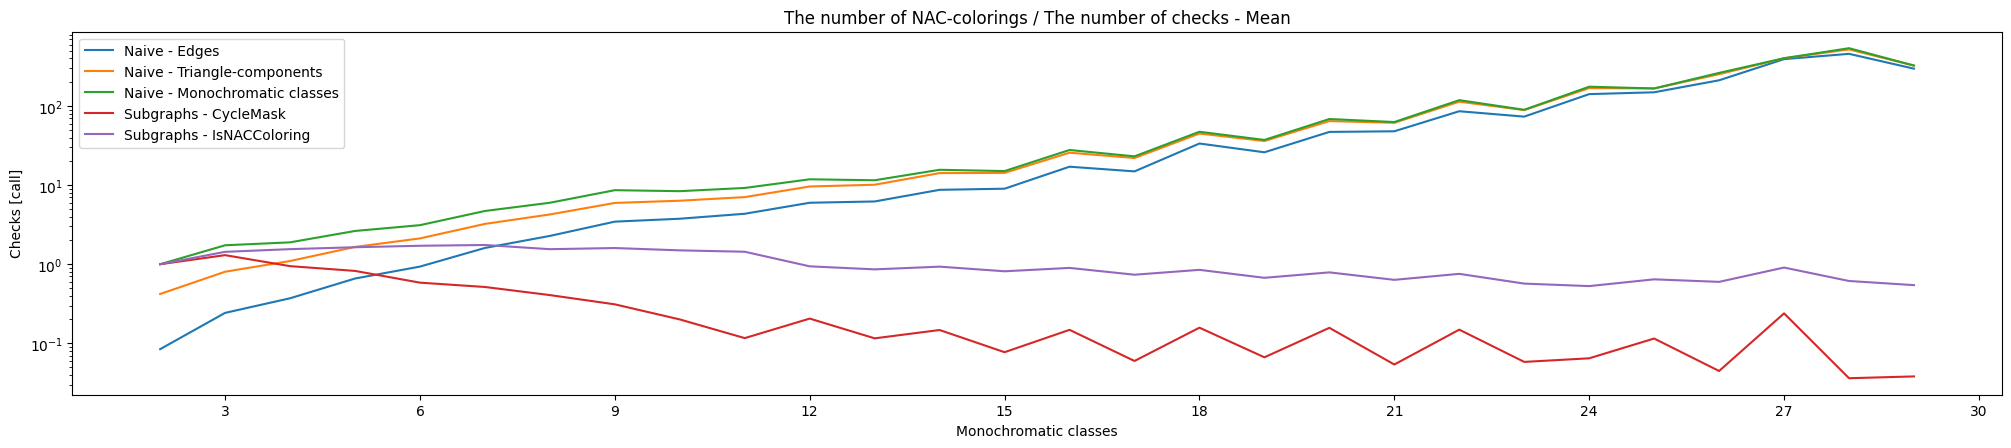

In [24]:
if True:
    [display(fig) for fig in plot_is_NAC_coloring_calls(df_analytics.query("split != 'naive-cycles'"))]